This work has made by Vitaliy Burlakov (a.k.a Vetak8):

[My GitHub](https://github.com/vetak8)

[My Kaggle](https://www.kaggle.com/vitaliyburlakov)

<a id="sec0"></a>
# [INDEX](#sec0)


1. [Import librarries](#sec1)
2. [Functions](#sec2)
3. [Data](#sec3)
4. [Naive model](#sec4)
5. [EDA](#sec5)
    * 5.1 [Categorical Columns analysis](#sec5.1)
    * 5.2 [Numerical Columns analysis](#sec5.2)
    * 5.3 [Target Variable](#sec5.3)
6. [PreProc Tabular Data](#sec6)

<a id="sec1"></a>
## [1. IMPORT LIBRIARES](#sec1)
[(INDEX)](#sec0)

In [366]:
# !pip install -q tensorflow==2.3

In [367]:
#аугментации изображений
# !pip install albumentations -q

In [368]:
pip install pymystem3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [369]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import emoji
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations
from textblob import TextBlob  # for sentiment analysis

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [370]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [371]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [372]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [373]:
!pip freeze > requirements.txt

<a id='sec2'> </a>
## [2. Functions](#sec2)
[(INDEX)](#sec0)


In [374]:
def get_boxplot(data,
                X_axis,
                Y_axis,
                hue=None,
                figsize=(7, 5),
                take_less_box=False,
               rotation=45):
    '''Function is called to plot boxplots
    ------
    data - pandas dataframe
    X_axis - column need to be reflected in X axis
    Y_axis - column need to be reflected in X axis
    take_less_box - Default is False. If need to plot only 7 boxes
    '''
    if take_less_box:
        fig, ax = plt.subplots(figsize=figsize)
        sns.boxplot(x=X_axis,
                    y=Y_axis,
                    hue=hue,
                    data=data.loc[data.loc[:, X_axis].isin(
                        data.loc[:, X_axis].value_counts().index[:7])]
                    )
        plt.xticks(rotation=rotation)
        ax.set_title(f'Boxplot for {X_axis} and {Y_axis}', fontsize=14)
        plt.show()

    else:
        fig, ax = plt.subplots(figsize=figsize)
        sns.boxplot(x=X_axis, y=Y_axis, hue=hue, data=data)
        plt.xticks(rotation=rotation)
        ax.set_title(f'Boxplot for {X_axis} and {Y_axis}', fontsize=14)
        plt.show()
        
        

def missing_vars(data, column, random_proba=True):
    '''Function is called for filling of missing data'''
    # With using probability and random choise

    if random_proba:
        col_name = data[column].value_counts().index.to_list(
        )  # get list of values
        col_distr = data[column].value_counts(
            normalize=True).values  # get list of probs
        missing = data[col].isnull()  # flag of missing val
        # substitute values from the list of names in accordance with the probability of meeting the name
        data.loc[missing, [column]] = np.random.choice(col_name,
                                                       size=len(data[missing]),
                                                       p=col_distr)

    # Using  most common in  column
    data[col] = data[col].fillna(data[col].value_counts().index[0])

In [375]:
def corr_matrix(data, det=True, pltx=10, plty=10):
    '''Funcion is called for making a correlation matrix'''

    corr = data.corr()
    if det:

        evals, evec = np.linalg.eig(corr)
        ev_product = np.prod(evals)

        print(f'Rank of Matrix: {np.linalg.matrix_rank(corr)}')
        print(f'Determinant of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(corr)}')

    plt.figure(figsize=(pltx, plty))
    sns.heatmap(corr[(corr >= .2) | (corr <= -.2)],
                cmap='viridis',
                vmin=-1.0,
                linewidths=0.1,
                annot=True,
                annot_kws={"size": 10},
                square=True)
#         sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()

In [376]:
# Create a function to get the subjectivity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

# Create a function to compute the negative, neutral and positive analysis
def get_analysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

In [377]:
class Outliers_detector():
    def __init__(self, df):
        self.df = df

    def get_IQR_outliers(self, column):
        '''Method is called to detect IQR outliers'''
        outliers = dict()
        q1, q3 = np.percentile(sorted(self.df[column]), [25, 75])

        IQR = q3 - q1

        l_b = q1 - (1.5 * IQR)  # lower bound
        u_b = q3 + (1.5 * IQR)  # upper bound
        outl_count = len(self.df[column][self.df[column] < l_b]) + len(
            self.df[column][self.df[column] > u_b])

        outliers['lower_bound'] = round(l_b, 3)
        outliers['upper_bound'] = round(u_b, 3)
        outliers['outlier_count'] = outl_count

        return outliers

In [378]:
class Encoder:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def label_encoder(self, column):
        '''Method for label encoding'''
        le = LabelEncoder()
        self.dataframe[column] = le.fit_transform(self.dataframe[column])

    def hot_encoder(self, column):
        '''Method for hot encoding'''
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        aux_df = pd.DataFrame(ohe.fit_transform(self.dataframe[[column]]))
        aux_df.columns = ohe.get_feature_names([f'hot_{column}'])
#         self.dataframe = self.dataframe.drop(col, axis=1)
        self.dataframe = pd.concat([self.dataframe, aux_df], axis=1)
        return self.dataframe

In [379]:
def get_regression_metrics(report_df,y_true, y_pred, name):
    '''Create and add metrics into a pandas DF after experiment'''
    y_true, y_pred = np.exp(y_true), np.exp(y_pred)

    report = pd.DataFrame(columns={'MAPE'}, data=[0])
    try:
        report['MAPE'] = mape(y_true, y_pred)*100
    except:
        report['MAPE'] = 'failed'
    report['MAE'] = mean_absolute_error(y_true, y_pred)
    report['MSE'] = mean_squared_error(y_true, y_pred)
    report['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [380]:
def to_log(df, cols_to_log):
    'smart log'
    for col in cols_to_log:
        a = df[col].min()
        if a <= 0:                        
            df[col] = np.log(df[col] + (int(abs(df[col].min()))+2))
        
        df[col] = np.log(df[col])
    return df

In [381]:
def remove_trash(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    
    text = re.sub(r'@[А-Яа-я0-9]+', '', text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove @
    text = re.sub(r'#', '', text)  # remove #
    text = re.sub(r'{', '', text)
    text = re.sub(r'»', '', text)
    text = re.sub(r'«', '', text)
    text = re.sub(r'}', '', text)
    text = re.sub("[.|/|-|\|,|!]", '', text)  # ~~~~~~~~~~~
    text = re.sub(r'^а-яА-Я', '', text)
    text = re.sub('^a-zA-Z', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)  # remove hyperlink
    text = re.sub(r'\n', '', text)
    text = re.sub(r'———————————————————————————', '', text)
    text = re.sub(r'•', '', text)
    text = re.sub(r'\d{4}', '', text)
    text = re.sub(r'\b\w{2}\b', '', text)


    text = text.strip()
    
    return re.sub(emoj, '', text)

<a id='sec3'></a>
## [3. DATA](#sec3)
[INDEX](#sec0)


Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [382]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')


In [383]:
# fill price in test set with NaN
test['price'] = np.nan

# let's mark where is train where is test set.
test['sample'] = 0
train['sample'] = 1
df_combined = test.append(train, sort=False).reset_index(
    drop=True)  # combine sets

In [384]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
sample                     1
dtype: int64

<a id='sec4'></a>
## [4. Model 1: Making "naive" model](#sec4)
[INDEX](#sec0)



This model is going to predict mean price based on model and production date.
We will compare other models with it.

In [385]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [386]:
# Naive model
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# Fill misses
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# Round
predicts = (predicts // 1000) * 1000

#MAPE
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


In [387]:
df_report = pd.DataFrame(data=None)

In [388]:
df_report = get_regression_metrics(df_report,np.log(data_test['price']),np.log(predicts.values[:, 0]), 'Naive model' )

In [389]:
df_report

MAPE           MAE           MSE           RMSE
Naive model  19.877351  347328.24327  8.691772e+11  932296.757864

<a id='sec5'></a>
## [5. EDA](#sec5)
[INDEX](#sec0)

 ### Missing Values

In [390]:
cols = df_combined.columns

# Show in percents
for col in df_combined.columns:
    pct_missing = np.mean(df_combined[col].isnull())
    print(f'{col} - {round(pct_missing*100)}%')

bodyType - 0.0%
brand - 0.0%
color - 0.0%
description - 0.0%
engineDisplacement - 0.0%
enginePower - 0.0%
fuelType - 0.0%
mileage - 0.0%
modelDate - 0.0%
model_info - 0.0%
name - 0.0%
numberOfDoors - 0.0%
productionDate - 0.0%
sell_id - 0.0%
vehicleConfiguration - 0.0%
vehicleTransmission - 0.0%
Владельцы - 0.0%
Владение - 65.0%
ПТС - 0.0%
Привод - 0.0%
Руль - 0.0%
price - 20.0%
sample - 0.0%


Column "Владение" has a lot misses. We are going to see it in detail later.


In [391]:
df_combined.sample(1)

bodyType brand       color  \
7399  внедорожник 5 дв.   BMW  коричневый   

                                            description engineDisplacement  \
7399  Авто в одних руках,все обслуживание  по реглам...            2.0 LTR   

     enginePower fuelType  mileage  modelDate model_info  ...     sell_id  \
7399     245 N12   бензин   107000       2014         X3  ...  1091374938   

               vehicleConfiguration  vehicleTransmission   Владельцы  \
7399  ALLROAD_5_DOORS AUTOMATIC 2.0       автоматическая  1 владелец   

                Владение       ПТС  Привод   Руль      price sample  
7399  4 года и 9 месяцев  Оригинал  полный  Левый  1590000.0      1  

[1 rows x 23 columns]

In [392]:
df_combined.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'price', 'sample'],
      dtype='object')

Rename columns removing spaces and substituting capital letters

In [393]:
columns = {
    'bodyType': 'body_type',
    'engineDisplacement': 'engine_displacement',
    'enginePower': 'engine_power',
    'fuelType': 'fuel_type',
    'modelDate': 'model_date',
    'numberOfDoors': 'doors_count',    
    'productionDate': 'production_date',
    'vehicleConfiguration': 'vehicle_configuration',
    'vehicleTransmission': 'vehicle_transmission',
    'Владельцы': 'owner_count',
    'Владение': 'owning_period',
    'ПТС': 'car_passport',
    'Привод': 'wheel_drive',
    'Руль': 'wheel_location',
    
}

In [394]:
test.rename(columns=columns,inplace=True)
train.rename(columns=columns,inplace=True)
df_combined.rename(columns=columns,inplace=True)

<a id='sec5.1'></a>
## [5.1. Categorical Columns analysis](#sec5.1)
[INDEX](#sec0)

In [395]:
cat_cols = ['body_type','brand',
            'color','fuel_type',
            'vehicle_transmission',
            'owner_count',
            'car_passport','wheel_drive',
            'wheel_location', 'model_info',
            'name', 'doors_count'
           ]

# **body_type**

In [396]:
df_combined['body_type'].unique()

array(['универсал 5 дв.', 'купе', 'седан', 'внедорожник 5 дв.', 'родстер',
       'лифтбек', 'хэтчбек 3 дв.', 'хэтчбек 5 дв.', 'купе-хардтоп',
       'внедорожник 3 дв.', 'минивэн', 'кабриолет',
       'пикап двойная кабина', 'внедорожник открытый', 'компактвэн',
       'седан 2 дв.', 'лимузин'], dtype=object)

Reducing the number of body types

In [397]:
body_type_map = {
    'седан':'седан',
    'внедорожник 5 дв.':'внедорожник',
    'внедорожник открытый':'внедорожник',
    'внедорожник 3 дв.':'внедорожник',
    'лифтбек':'седан',
    'хэтчбек 5 дв.':'хэтчбек',
    'хэтчбек 3 дв.':'хэтчбек',
    'универсал 5 дв.':'универсал',
    'купе-хардтоп':'купе',
    'компактвэн':'минивэн',
    'пикап двойная кабина':'пикап',
    'седан 2 дв.':'седан',
    'лимузин':'лимузин'
    
    
    
}

In [398]:
df_combined['body_type'] = df_combined['body_type'].map(body_type_map)

In [399]:
cols_to_fill = ['body_type']

for col in cols_to_fill:
    missing_vars(df_combined, col)
    df_combined[col] = df_combined[col].astype('str')

In [400]:
df_combined['body_type'].unique()

array(['универсал', 'внедорожник', 'хэтчбек', 'седан', 'купе', 'лимузин',
       'пикап', 'минивэн'], dtype=object)

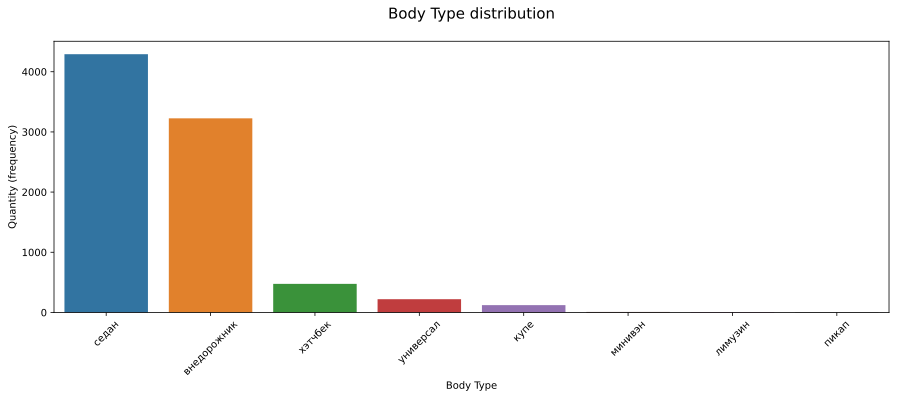

In [401]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(df_combined['body_type'], order=df_combined['body_type'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Body Type distribution\n', fontsize=15)
plt.xlabel('Body Type')
plt.ylabel('Quantity (frequency)');

The most popular body type is 'седан', then 'внедорожник'

Let's see how it is impact on price. In addition, let's see whether the number ow owners impact on price

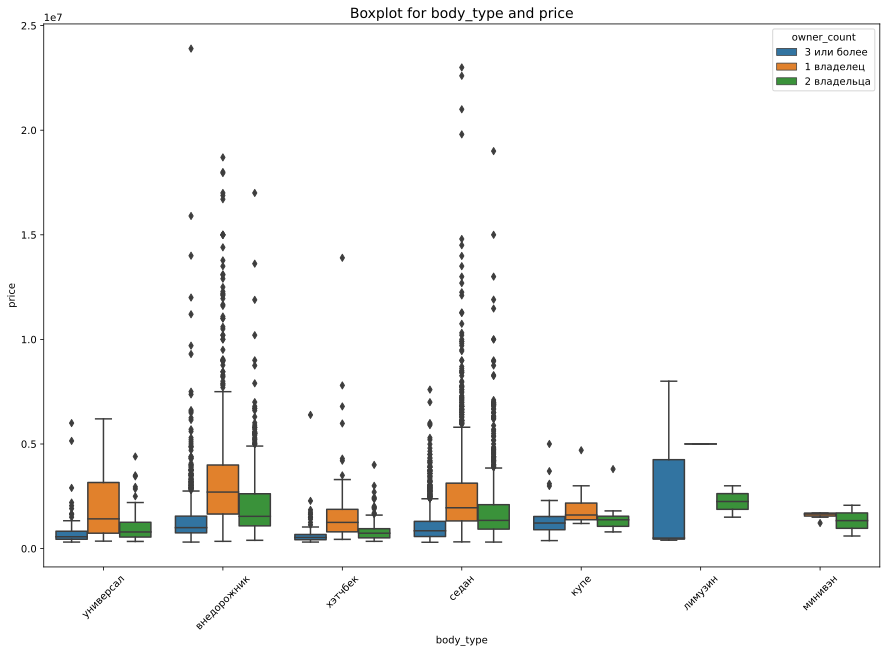

In [402]:
get_boxplot(df_combined, 'body_type', 'price', figsize=(
    15, 10), hue='owner_count', take_less_box=True)

We can see that quantity of owners impacts on the final price. if car has lots of owners , then less final price. Also, body type itself impact on price car. All wheel drive cars in average more expensive than others.

Or maybe it is depend on age of car? More older car has more owners? We will check bellow.

# **brand**

In [403]:
df_combined.brand.unique()

array(['MERCEDES', 'BMW', 'AUDI'], dtype=object)

In [404]:
df_combined.brand.isna().sum()

0

There is no passses. And not much count of brands

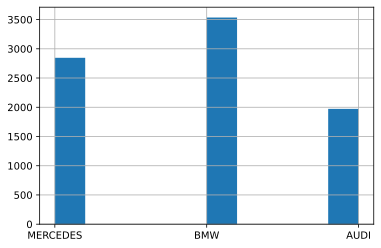

In [405]:
df_combined.brand.hist()

Distribution of brands is normal

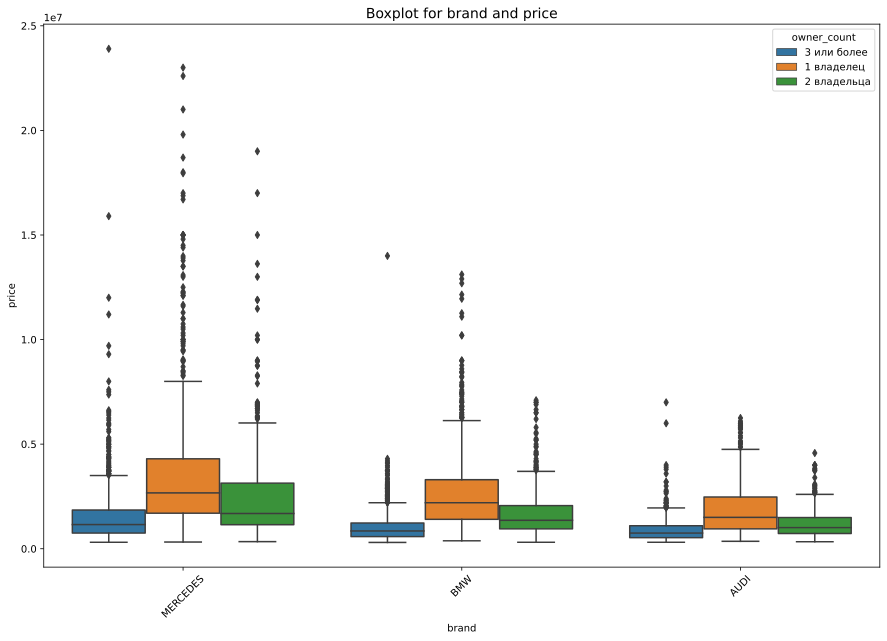

In [406]:
get_boxplot(df_combined, 'brand', 'price', figsize=(
    15, 10), hue='owner_count', take_less_box=True)

We observe that, on average, the price of cars with fewer owners is higher for each brand, but there are exceptions. This may be due to the rarity or high liquidity of the car

# **color**

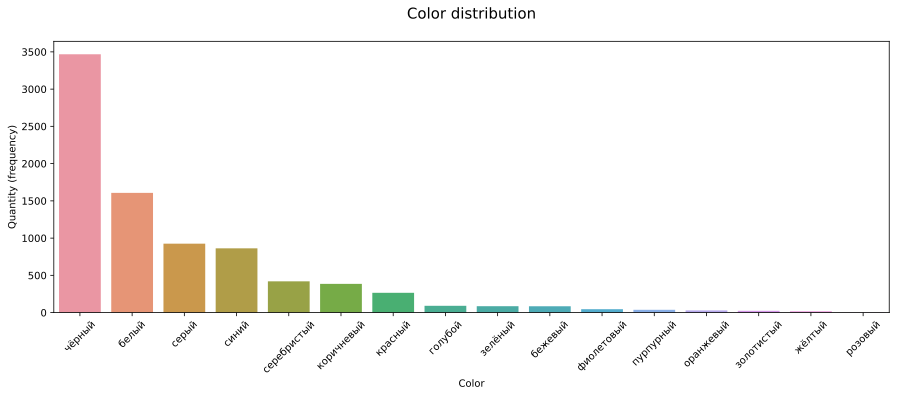

In [407]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(df_combined['color'], order=df_combined['color'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Color distribution\n', fontsize=15)
plt.xlabel('Color')
plt.ylabel('Quantity (frequency)');

We see the most popular color is black, then white.

Let's name the unpopular colors 'other'

In [408]:
# Let's take colors with occurence less then 5%
unpop_colors = df_combined.color.value_counts()[df_combined.color.value_counts(normalize=True).values<0.05].index.to_list()

In [409]:
df_combined['color'] = df_combined['color'].apply(lambda x:'other' if x in unpop_colors else x)

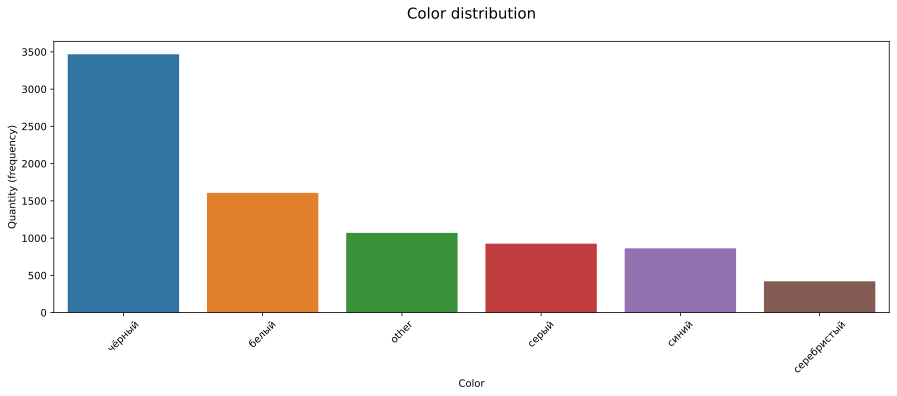

In [410]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(df_combined['color'], order=df_combined['color'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Color distribution\n', fontsize=15)
plt.xlabel('Color')
plt.ylabel('Quantity (frequency)');

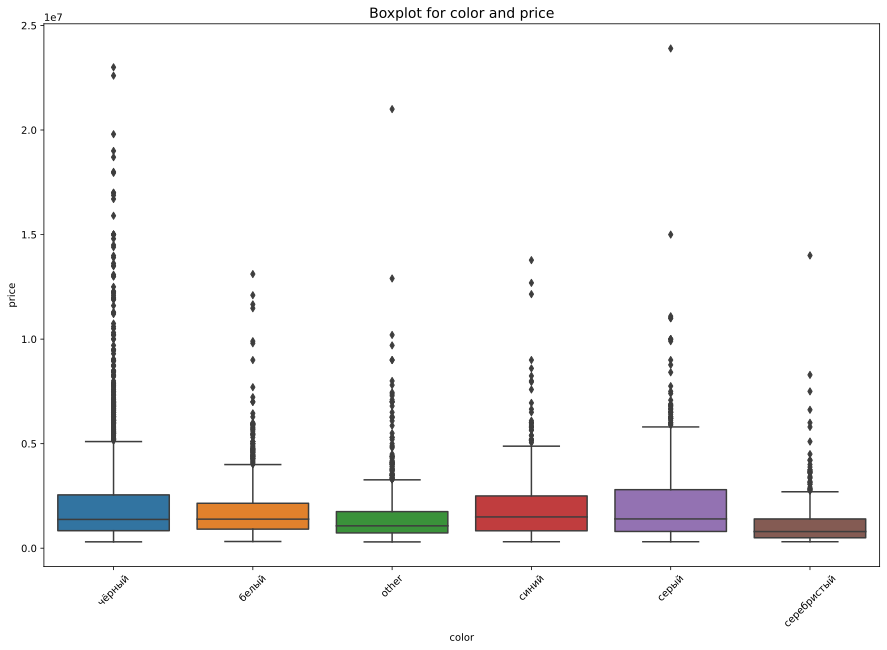

In [411]:
get_boxplot(df_combined, 'color', 'price', figsize=(
    15, 10), take_less_box=True)

We see black and silver cars has more hight average price, particularly black.

# **fuel_type**

In [412]:
df_combined.fuel_type.value_counts()

бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuel_type, dtype: int64

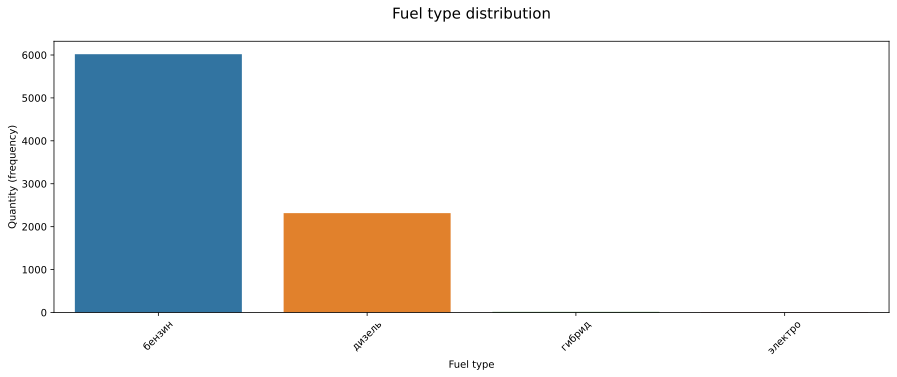

In [413]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(df_combined['fuel_type'], order=df_combined['fuel_type'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Fuel type distribution\n', fontsize=15)
plt.xlabel('Fuel type')
plt.ylabel('Quantity (frequency)');

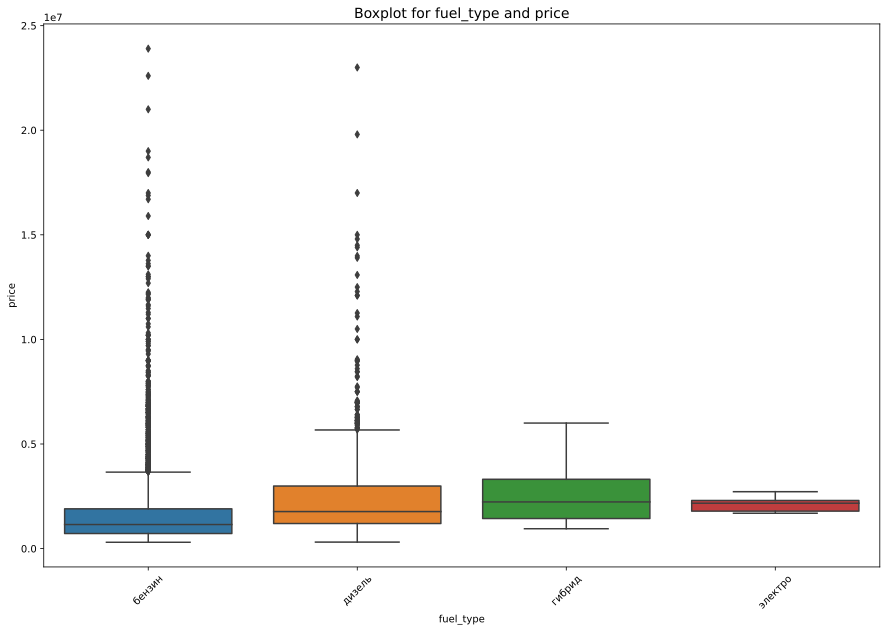

In [414]:
get_boxplot(df_combined, 'fuel_type', 'price', figsize=(
    15, 10), take_less_box=True)

Gas and diesel fuel type influence on target aproximetly equal. We can nothing to say about gybrid and electro cause there is not much examples

Let's name insignificant fuel types as 'other'

In [415]:
df_combined['fuel_type'] = df_combined['fuel_type'].apply(lambda x:'other' if x in ['гибрид', 'электро'] else x)

# **vehicle_transmission**

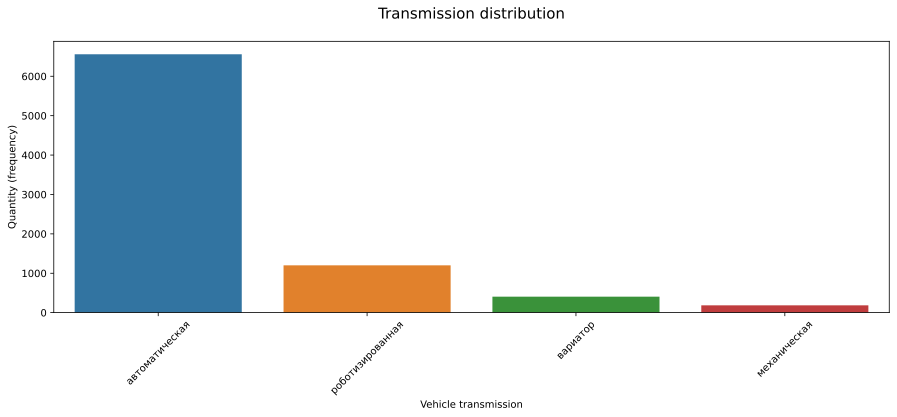

In [416]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(df_combined['vehicle_transmission'], order=df_combined['vehicle_transmission'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Transmission distribution\n', fontsize=15)
plt.xlabel('Vehicle transmission')
plt.ylabel('Quantity (frequency)');

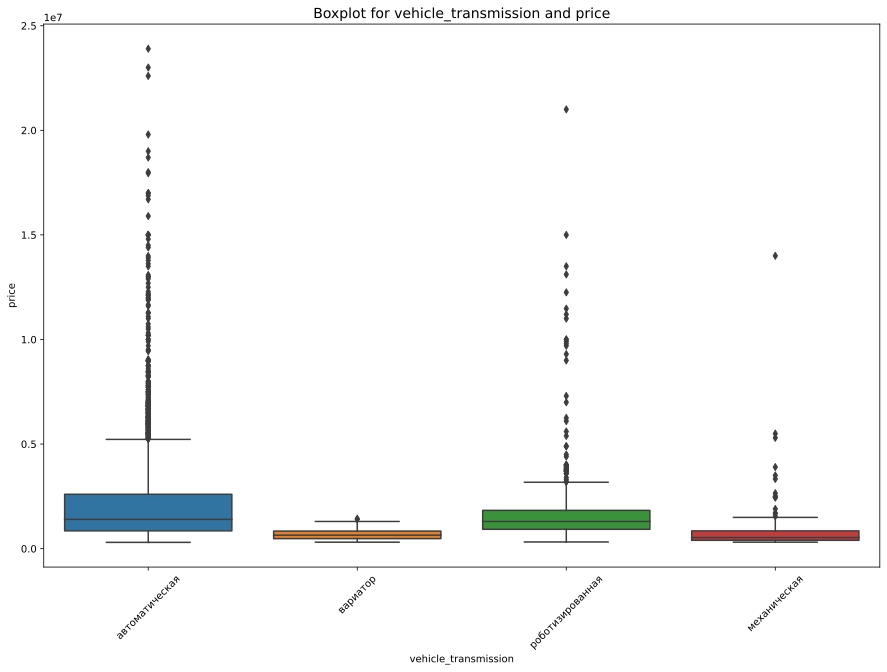

In [417]:
get_boxplot(df_combined, 'vehicle_transmission', 'price', figsize=(
    15, 10), take_less_box=True)

We see robot and automat transmission cars has higher price

# **owner_count**

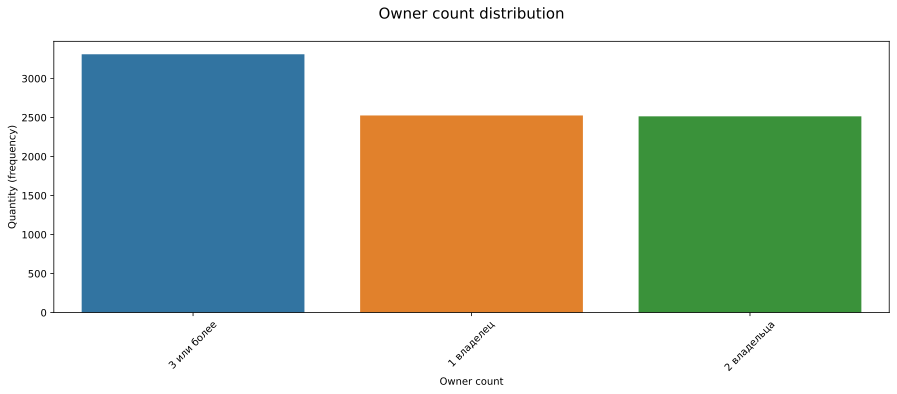

In [418]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(df_combined['owner_count'], order=df_combined['owner_count'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Owner count distribution\n', fontsize=15)
plt.xlabel('Owner count')
plt.ylabel('Quantity (frequency)');

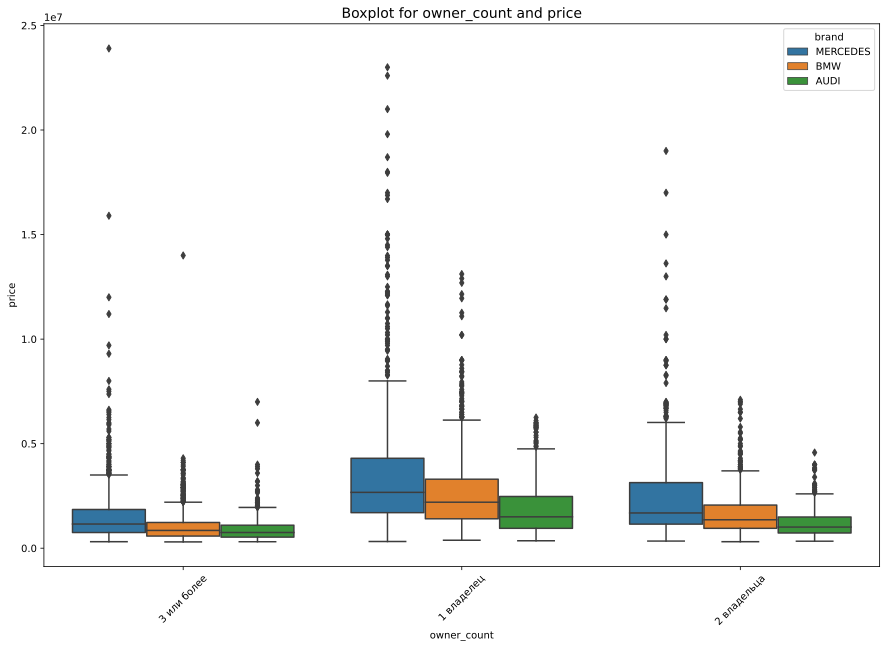

In [419]:
get_boxplot(df_combined, 'owner_count', 'price', figsize=(
    15, 10),hue='brand', take_less_box=True)

# **car_passport**

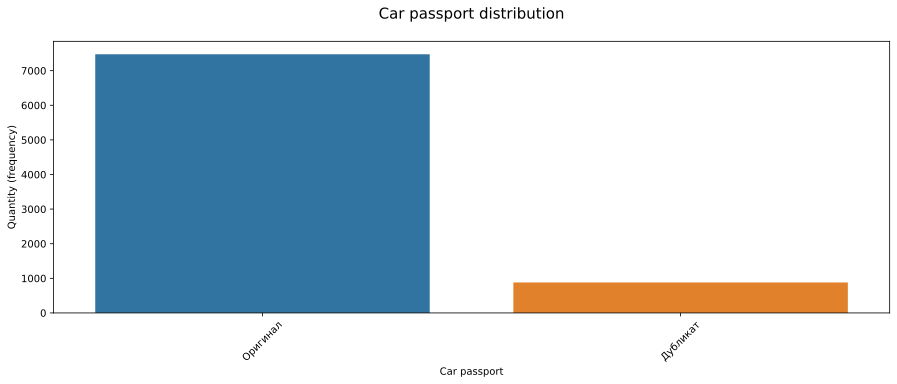

In [420]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(df_combined['car_passport'], order=df_combined['car_passport'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Car passport distribution\n', fontsize=15)
plt.xlabel('Car passport')
plt.ylabel('Quantity (frequency)');

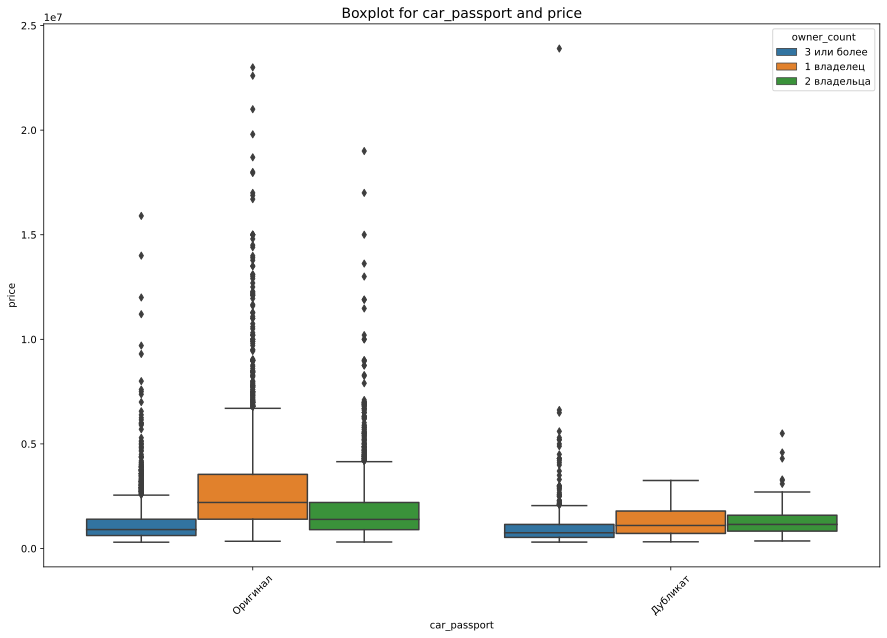

In [421]:
get_boxplot(df_combined, 'car_passport', 'price', figsize=(
    15, 10),hue='owner_count', take_less_box=True)

Cars that have 1 or 2 owners, but at the same time a duplicate, look strange. The reason may be the loss of the vehicle title, which speaks of the seller's irresponsibility and his attitude towards the car or it means count of owners in duplicate car passport and this misleads the buyer about the true number of owners . It is worth noting such cars in features engineering.

In [422]:
df_combined['owner_count'] = df_combined['owner_count'].astype('category').cat.codes
df_combined['car_passport'] = df_combined['car_passport'].astype('category').cat.codes
# 0 owners - '-1'
# 1 owner - '0' 
# 2 owners - '1'
# 3 и more owners - '2'

In [423]:
def is_strange_passport(car_passport, owners_count):
    if car_passport == 0:
        if owners_count != 2:
            return 1
        else:
            return 0
    else:
        return 0

In [424]:
df_combined[['car_passport','owner_count']].apply(lambda x:is_strange_passport(*x), axis=1).value_counts(normalize=True)*100

0    98.730995
1     1.269005
dtype: float64

There are about 1% strange passports. Let's mark them. 

*In the future we'll see no impact upon result.*

In [425]:
df_combined['is_strange_passport'] = df_combined[['car_passport','owner_count']].apply(lambda x:is_strange_passport(*x), axis=1)

# **wheel_drive**

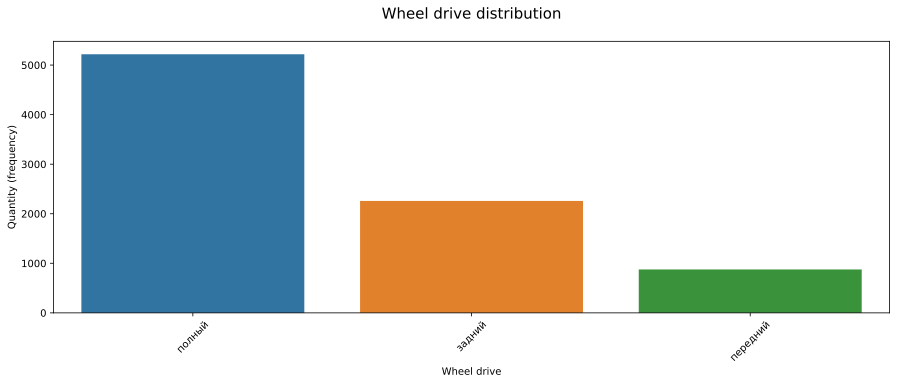

In [426]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(df_combined['wheel_drive'], order=df_combined['wheel_drive'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Wheel drive distribution\n', fontsize=15)
plt.xlabel('Wheel drive')
plt.ylabel('Quantity (frequency)');

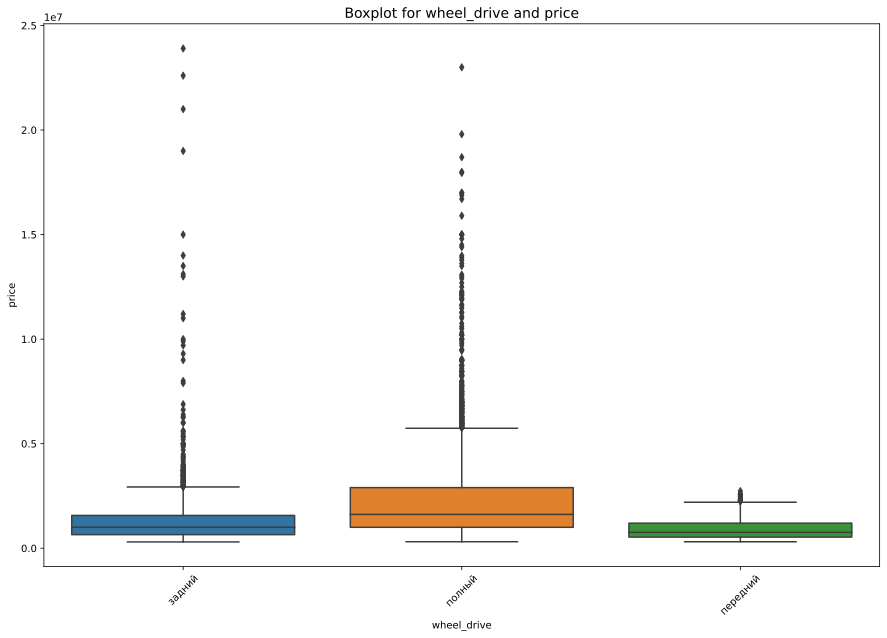

In [427]:
get_boxplot(df_combined, 'wheel_drive', 'price', figsize=(
    15, 10), take_less_box=True)

# **wheel_location**

In [428]:
df_combined.wheel_location.value_counts()

Левый     8351
Правый       2
Name: wheel_location, dtype: int64

In [429]:
test.wheel_location.value_counts()

Левый    1671
Name: wheel_location, dtype: int64

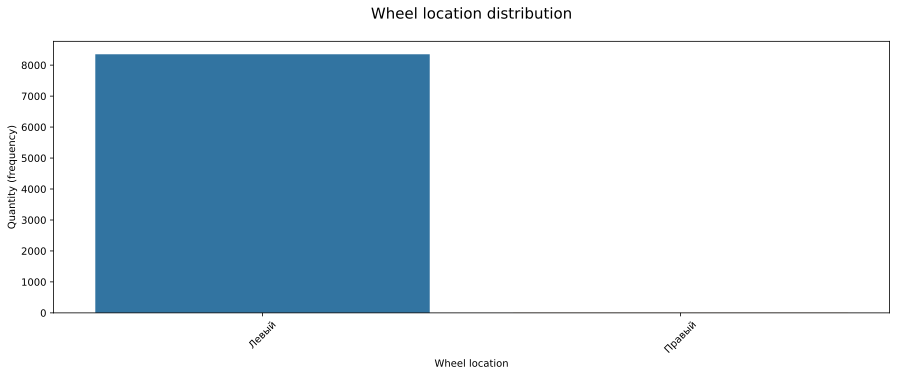

In [430]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(df_combined['wheel_location'], order=df_combined['wheel_location'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Wheel location distribution\n', fontsize=15)
plt.xlabel('Wheel location')
plt.ylabel('Quantity (frequency)');

This is useless column cause there are only 2 right wheel location cars. And test dataset has no right wheel location cars. Column will be deleted.

*And this move improve result*

# **name**

In [431]:
df_combined.name.nunique()

976

In [432]:
df_combined.name[0]

'300 3.0 AT (220 л.с.)'

Too many unique elements, lets make it shorter by taking first word.

In [433]:
df_combined['name'] = df_combined.name.apply(lambda x:str(x.split()[0]))

In [434]:
df_combined.name.unique()

array(['300', '640d', '325xi', '318i', '520d', '540i', '3.0d', '350',
       '1.8', '320i', '500', '2.0', '650i', '116i', '25d', '20d', '330i',
       '200', '320d', '118i', '30d', '630i', '2.4', '320', '1.4', '428i',
       '63', '400', '2.5', '35i', '180', '18i', '520i', '3.0si', '5.2',
       '4.4', '750i', '528i', '450', '750d', '730Ld', '2.8', '560', '20i',
       '30i', '55', '535i', '4.2', '4.0', 'Competition', '3.0', 'M50d',
       '250', '730d', '525i', '50i', '43', '530d', '545i', '630d', '328i',
       '120i', '220', '119', '600', '48i', '280', '750Li', '1.2', 'L1',
       '3.6', '230', '520Li', '740Li', '4.8is', '325i', '740i', '525d',
       'M550d', '28i', '4.4i', 'Long', '530i', '335i', '523i', '3.1',
       '740d', '420d', 'L2', '550', '645i', '730Li', '640i', 'GT', '240',
       '3.0i', '2.0d', '435i', '380', 'xDrive18d', '4.8i', '45', 'L3',
       'S', 'S-tronic', '4.1d', '35d', 'M760Li', '420i', '420', '316i',
       '18d', '1.6', 'ActiveHybrid', '530xi', '40d', '8ti

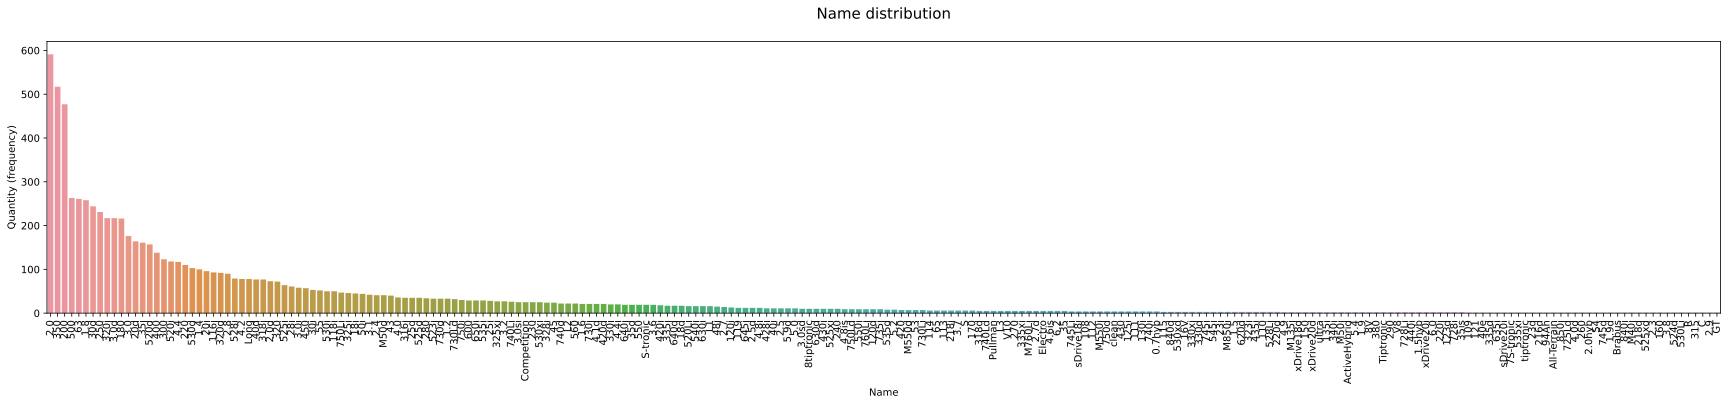

In [435]:
plt.figure(figsize=(30, 5), dpi=100)
sns.countplot(df_combined['name'], order=df_combined['name'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Name distribution\n', fontsize=15)
plt.xlabel('Name')
plt.ylabel('Quantity (frequency)');

It looks like this column carries unnecessary information. Perhaps we will delete it later.

## **doors_count**

In [436]:
df_combined.doors_count.value_counts()

5    3854
4    3636
2     802
3      61
Name: doors_count, dtype: int64

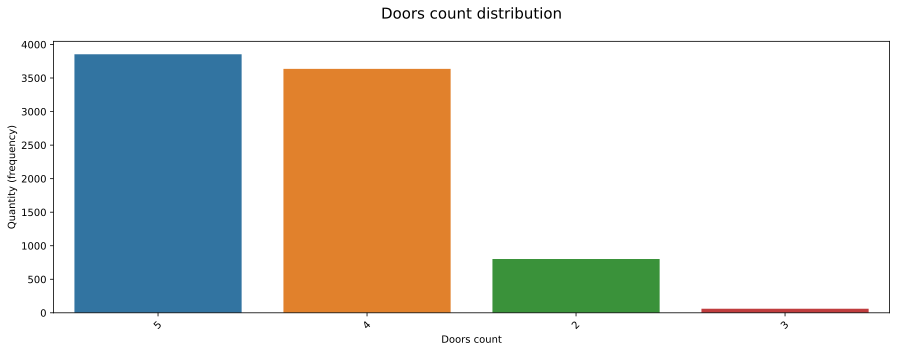

In [437]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(df_combined['doors_count'], order=df_combined['doors_count'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Doors count distribution\n', fontsize=15)
plt.xlabel('Doors count')
plt.ylabel('Quantity (frequency)');

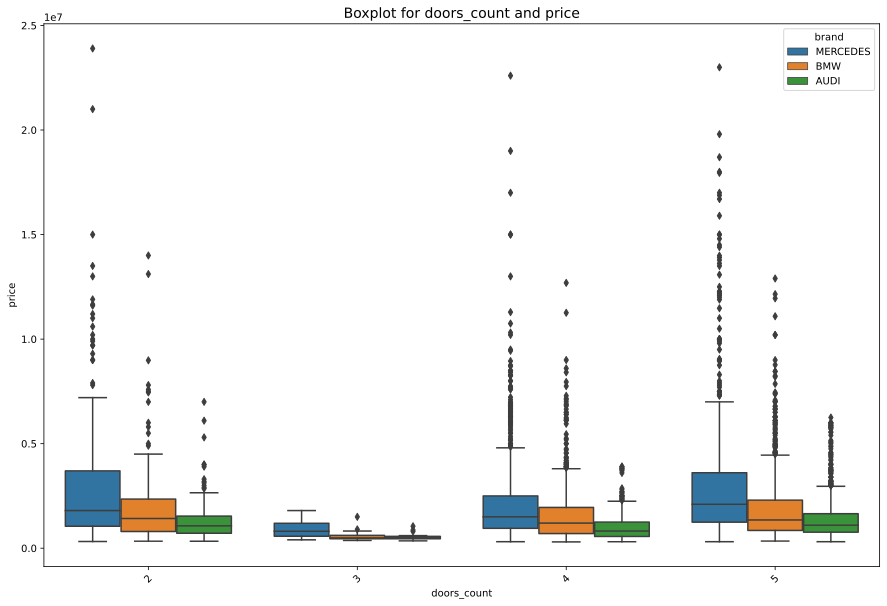

In [438]:
get_boxplot(df_combined, 'doors_count', 'price', figsize=(
    15, 10),hue='brand', take_less_box=True)

<a id='sec5.2'></a>
## [5.2. Numerical Columns analysis](#sec5.2)
[INDEX](#sec0)

In [439]:
num_cols = ['engine_displacement', 'engine_power', 'mileage', 'production_date','model_date']

In [440]:
outliers = Outliers_detector(df_combined)
outliers_train = Outliers_detector(df_combined[df_combined['sample'] == 1])
outliers_test = Outliers_detector(df_combined[df_combined['sample'] == 0])

## **engine_displacement**

In [441]:
df_combined.engine_displacement.unique()

array(['3.0 LTR', '2.5 LTR', '2.0 LTR', '3.5 LTR', '1.8 LTR', '2.2 LTR',
       '5.5 LTR', '4.8 LTR', '1.6 LTR', '4.7 LTR', '4.0 LTR', '1.5 LTR',
       '2.4 LTR', '1.4 LTR', '2.1 LTR', '5.2 LTR', '4.4 LTR', '2.8 LTR',
       '4.2 LTR', '3.2 LTR', '6.0 LTR', '3.7 LTR', '5.0 LTR', '1.2 LTR',
       '3.6 LTR', '2.3 LTR', '6.2 LTR', '1.7 LTR', '1.3 LTR', '5.4 LTR',
       '3.1 LTR', '2.6 LTR', '3.8 LTR', '4.1 LTR', '2.9 LTR', '6.6 LTR',
       '5.9 LTR', 'undefined LTR', '2.7 LTR', '0.7 LTR', '1.9 LTR',
       '4.3 LTR', '5.8 LTR', '4.9 LTR', '3.4 LTR', '6.3 LTR', '5.6 LTR',
       '4.6 LTR'], dtype=object)

We see unndefined LTR, it meight be electro cars. Let's check it out

In [442]:
df_combined[df_combined['engine_displacement']=='undefined LTR']

body_type brand        color  \
1005   хэтчбек   BMW  серебристый   
3967   хэтчбек   BMW       чёрный   
5396   хэтчбек   BMW       чёрный   
5397   хэтчбек   BMW        other   
7533   хэтчбек   BMW        белый   
7954   хэтчбек   BMW       чёрный   

                                            description engine_displacement  \
1005                                                  .       undefined LTR   
3967  Автомобиль в наличии Москве , с ПТС , производ...       undefined LTR   
5396  BMW i3 Электромобиль с бензиновым генератором,...       undefined LTR   
5397  Прибыло из Америки в августе 20 года. Полная и...       undefined LTR   
7533  В наличии! Автомобиль куплен в США! Комплектац...       undefined LTR   
7954  Авто в идеальном состоянии\nЕсть REX (range ex...       undefined LTR   

     engine_power fuel_type  mileage  model_date model_info  ...  \
1005      170 N12     other    89942        2013         I3  ...   
3967      184 N12     other     9000        2017         I3  ...   
5396      170 N12     other    39500        2017         I3  ...   
5397      170 N12     other    28800        2017         I3  ...   
7533      170 N12     other    35810        2013         I3  ...   
7954      170 N12     other    60000        2013         I3  ...   

            vehicle_configuration  vehicle_transmission  owner_count  \
1005  HATCHBACK_5_DOORS AUTOMATIC        автоматическая            0   
3967  HATCHBACK_5_DOORS AUTOMATIC        автоматическая            0   
5396  HATCHBACK_5_DOORS AUTOMATIC        автоматическая            0   
5397  HATCHBACK_5_DOORS AUTOMATIC        автоматическая            0   
7533  HATCHBACK_5_DOORS AUTOMATIC        автоматическая            0   
7954  HATCHBACK_5_DOORS AUTOMATIC        автоматическая            0   

            owning_period car_passport wheel_drive  wheel_location      price  \
1005                  NaN            1      задний           Левый        NaN   
3967                  NaN            1      задний           Левый  2719000.0   
5396  2 года и 11 месяцев            1      задний           Левый  2299711.0   
5397                  NaN            1      задний           Левый  2170000.0   
7533                  NaN            1      задний           Левый  1690000.0   
7954                  NaN            1      задний           Левый  1790000.0   

      sample is_strange_passport  
1005       0                   0  
3967       1                   0  
5396       1                   0  
5397       1                   0  
7533       1                   0  
7954       1                   0  

[6 rows x 24 columns]

We were right. Let's remove useless part ('LTR') and name undefined elements by 0

In [443]:
df_combined['engine_displacement'] = df_combined['engine_displacement'].apply(lambda x:float(str(x).split()[0]) if 'undefined' not in str(x) else 0)

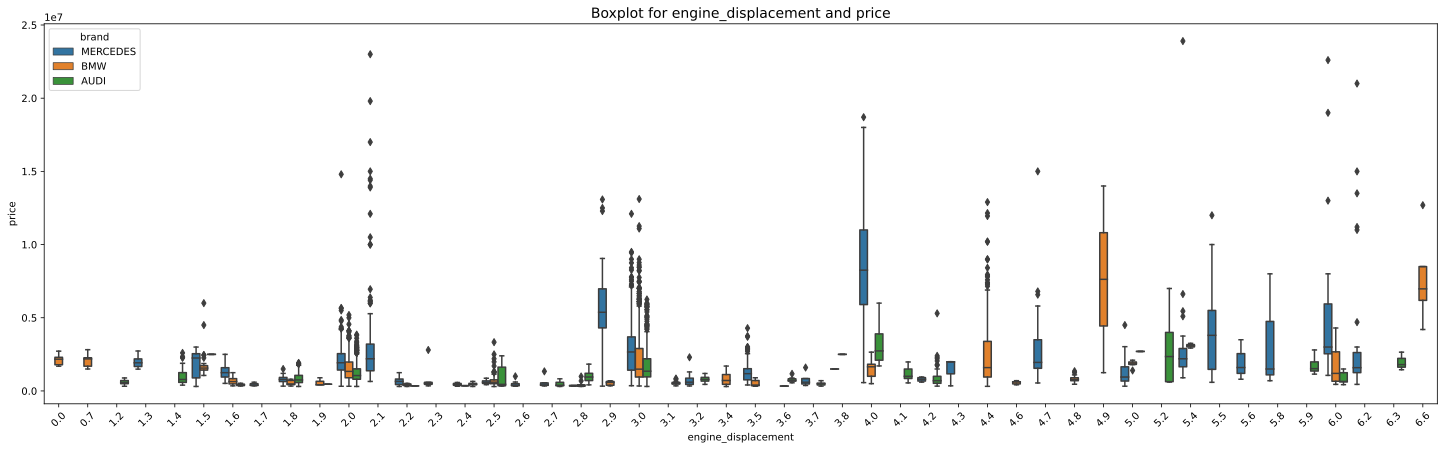

In [444]:
get_boxplot(df_combined,'engine_displacement', 'price',hue='brand', figsize=(25, 7))

We can see,on average, the larger the engine volume, the higher the price. But some 2.1 engine volume mersedeses has high price. Let's see in more detail

In [445]:
mersedeses_2_1 = df_combined[(df_combined['price'] > 500000) & (df_combined['engine_displacement'] == 2.1)].name.index

df_combined.loc[mersedeses_2_1, ['is_2_1_mers']] =1
df_combined['is_2_1_mers'] = df_combined['is_2_1_mers'].fillna(0)

We are going to mark them later. May be they has good engines or it's fresh models.

*This move make no sence*

{'lower_bound': 0.5, 'upper_bound': 4.5, 'outlier_count': 699}


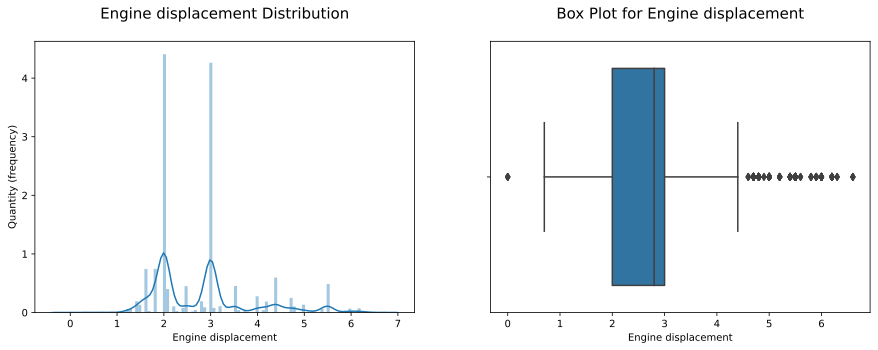

In [446]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(df_combined.engine_displacement.values, bins=100)
plt.title('Engine displacement Distribution\n', fontsize=15)
plt.xlabel('Engine displacement')
plt.ylabel('Quantity (frequency)')
plt.subplot(122)
sns.boxplot(df_combined.engine_displacement.values)
plt.title('Box Plot for Engine displacement\n', fontsize=15)
plt.xlabel('Engine displacement');
df_combined['engine_displacement'].describe()

print(outliers.get_IQR_outliers('engine_displacement'))
# print(outliers_train.get_IQR_outliers('engine_displacement'))
# print(outliers_test.get_IQR_outliers('engine_displacement'))

We have outliers let's mark them

In [447]:
displacement_outliers = df_combined[df_combined['engine_displacement'] > 4.5].index
df_combined['displacement_outlier'] = 0 # Make 0 values column
df_combined.loc[displacement_outliers, ['displacement_outlier']] = 1 # Fill column with 1 

This move not improve result. Cancel it

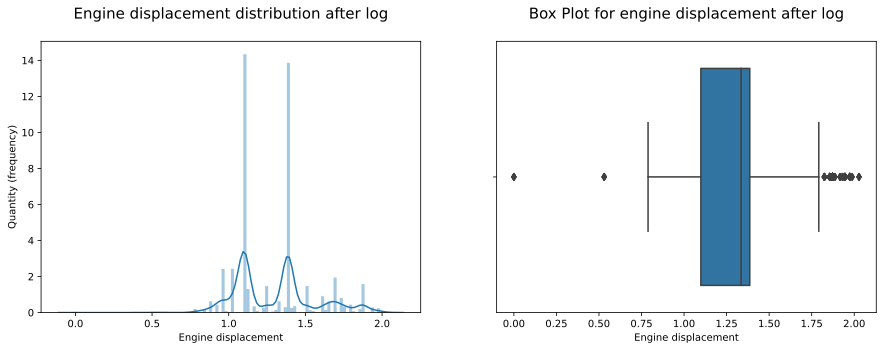

In [448]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(np.log(df_combined.engine_displacement.values + 1), bins=100)
plt.title('Engine displacement distribution after log\n', fontsize=15)
plt.xlabel('Engine displacement')
plt.ylabel('Quantity (frequency)')
plt.subplot(122)
sns.boxplot(np.log(df_combined.engine_displacement.values + 1))
plt.title('Box Plot for engine displacement after log\n', fontsize=15)
plt.xlabel('Engine displacement');



Logarithm does not change the situation

## **engine_power**


In [449]:
df_combined.engine_power.unique()

array(['220 N12', '313 N12', '218 N12', '136 N12', '190 N12', '340 N12',
       '245 N12', '316 N12', '170 N12', '160 N12', '231 N12', '388 N12',
       '180 N12', '367 N12', '115 N12', '184 N12', '177 N12', '455 N12',
       '422 N12', '163 N12', '249 N12', '272 N12', '224 N12', '122 N12',
       '557 N12', '333 N12', '306 N12', '156 N12', '150 N12', '264 N12',
       '450 N12', '555 N12', '407 N12', '130 N12', '400 N12', '204 N12',
       '469 N12', '192 N12', '210 N12', '211 N12', '239 N12', '200 N12',
       '350 N12', '420 N12', '300 N12', '381 N12', '265 N12', '258 N12',
       '390 N12', '197 N12', '120 N12', '544 N12', '193 N12', '235 N12',
       '233 N12', '394 N12', '355 N12', '421 N12', '320 N12', '585 N12',
       '105 N12', '280 N12', '194 N12', '132 N12', '639 N12', '250 N12',
       '335 N12', '510 N12', '116 N12', '360 N12', '238 N12', '225 N12',
       '625 N12', '571 N12', '507 N12', '286 N12', '372 N12', '575 N12',
       '408 N12', '310 N12', '354 N12', '255 N12', 

There are useless part of text (N12), let's cut it out and transform to integer type

In [450]:
df_combined['engine_power'] = df_combined['engine_power'].apply(lambda x:int(str(x).split()[0]) )

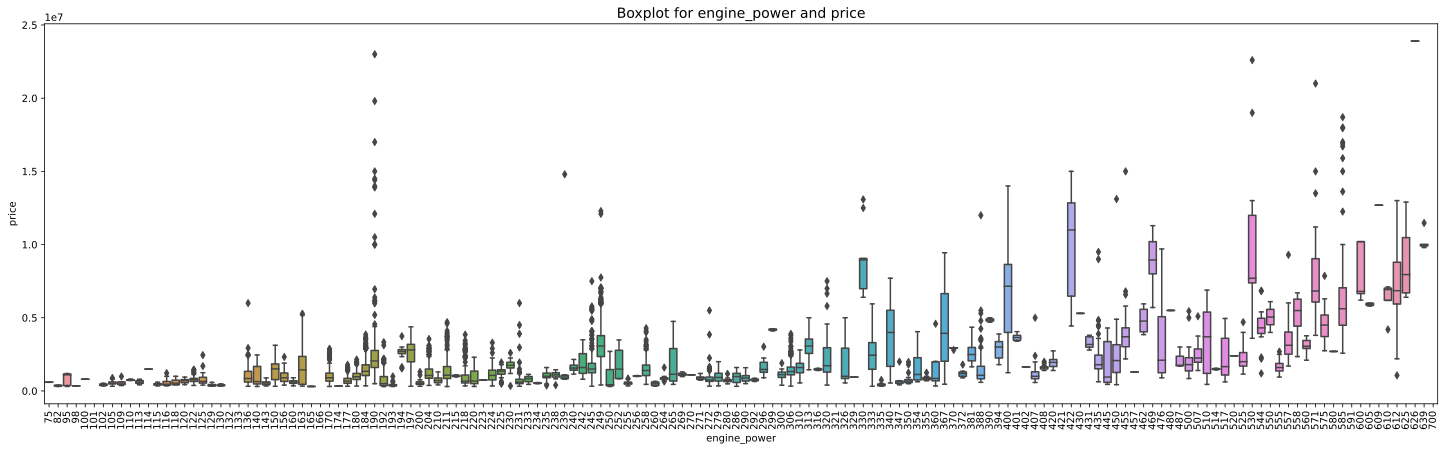

In [451]:
get_boxplot(df_combined,'engine_power', 'price', figsize=(25, 7), rotation=90)

The larger engine power the higher car price. But we see a spike in prices near the border of the horsepower tax increase, namely 190 and 249.
Let's mark them.

In [452]:
before_tax_increase = df_combined[df_combined['engine_power'] == 190].index # Desired values index list
df_combined['horses_190'] = 0 # Make 0 values column
df_combined.loc[before_tax_increase, ['horses_190']] = 1 # Fill column with 1 

*This move make no sence*

In [453]:
a = outliers.get_IQR_outliers('engine_displacement')

{'lower_bound': 1.0, 'upper_bound': 489.0, 'outlier_count': 493}


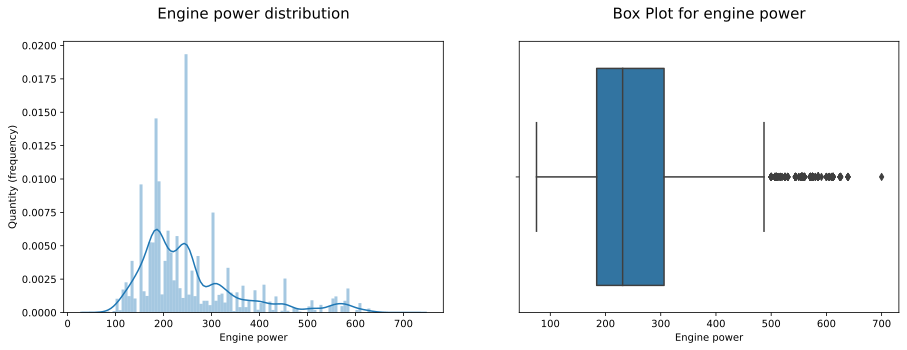

In [454]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(df_combined.engine_power.values, bins=100)
plt.title('Engine power distribution\n', fontsize=15)
plt.xlabel('Engine power')
plt.ylabel('Quantity (frequency)')
plt.subplot(122)
sns.boxplot(df_combined.engine_power.values)
plt.title('Box Plot for engine power\n', fontsize=15)
plt.xlabel('Engine power');
df_combined['engine_power'].describe()

print(outliers.get_IQR_outliers('engine_power'))
# print(outliers_train.get_IQR_outliers('engine_power'))
# print(outliers_test.get_IQR_outliers('engine_power'))

Let's mark outliters

In [455]:
power_outliers = df_combined[df_combined['engine_power'] >489].index
df_combined['power_outlier'] = 0 # Make 0 values column
df_combined.loc[power_outliers, ['power_outlier']] = 1 # Fill column with 1 

This move improve  result 

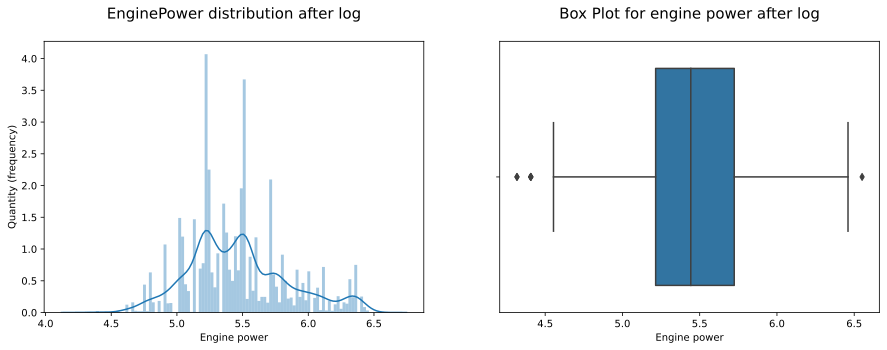

In [456]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(np.log(df_combined.engine_power.values), bins=100)
plt.title('EnginePower distribution after log\n', fontsize=15)
plt.xlabel('Engine power')
plt.ylabel('Quantity (frequency)')
plt.subplot(122)
sns.boxplot(np.log(df_combined.engine_power.values))
plt.title('Box Plot for engine power after log\n', fontsize=15)
plt.xlabel('Engine power');



After logatithm it seems much better

## **mileage**

{'lower_bound': -102511.0, 'upper_bound': 328841.0, 'outlier_count': 161}
{'lower_bound': -104046.875, 'upper_bound': 331228.125, 'outlier_count': 113}
{'lower_bound': -99630.75, 'upper_bound': 324379.25, 'outlier_count': 37}


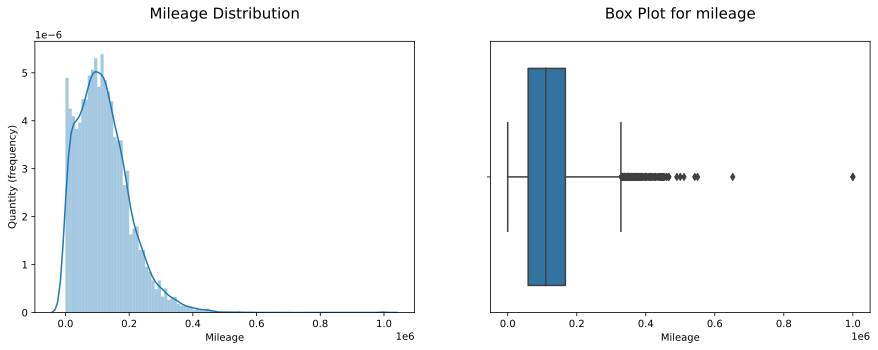

In [457]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(df_combined.mileage.values, bins=100)
plt.title('Mileage Distribution\n', fontsize=15)
plt.xlabel('Mileage')
plt.ylabel('Quantity (frequency)')
plt.subplot(122)
sns.boxplot(df_combined.mileage.values)
plt.title('Box Plot for mileage\n', fontsize=15)
plt.xlabel('Mileage');
df_combined['mileage'].describe()

print(outliers.get_IQR_outliers('mileage'))
print(outliers_train.get_IQR_outliers('mileage'))
print(outliers_test.get_IQR_outliers('mileage'))

We have outlier, let's mark them

In [458]:
mileage_outliers = df_combined[df_combined['mileage'] > 328841.0].index
df_combined['mileage_outliers'] = 0 # Make 0 values column
df_combined.loc[mileage_outliers, ['mileage_outliers']] = 1 # Fill column with 1 

This move improve result. Cancel it

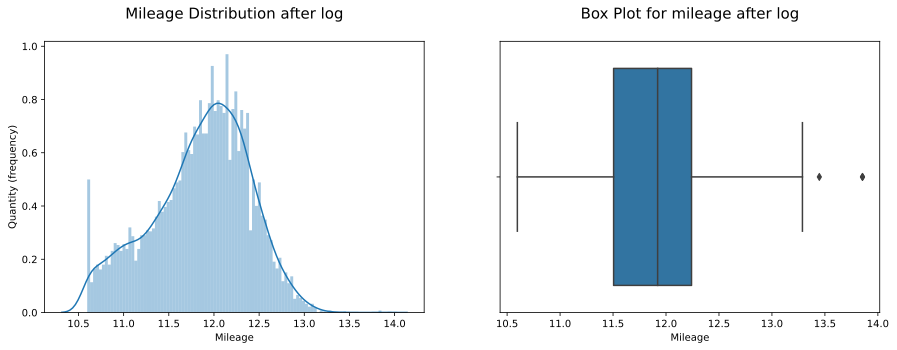

In [459]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(np.log(df_combined.mileage.values+40000), bins=100)
plt.title('Mileage Distribution after log\n', fontsize=15)
plt.xlabel('Mileage')
plt.ylabel('Quantity (frequency)')
plt.subplot(122)
sns.boxplot(np.log(df_combined.mileage.values+40000))
plt.title('Box Plot for mileage after log\n', fontsize=15)
plt.xlabel('Mileage');



The number 40000 is good for normalization

Mileage variable has biased destribution shifted to the left. Let's try to logarithm.

## **model_date**

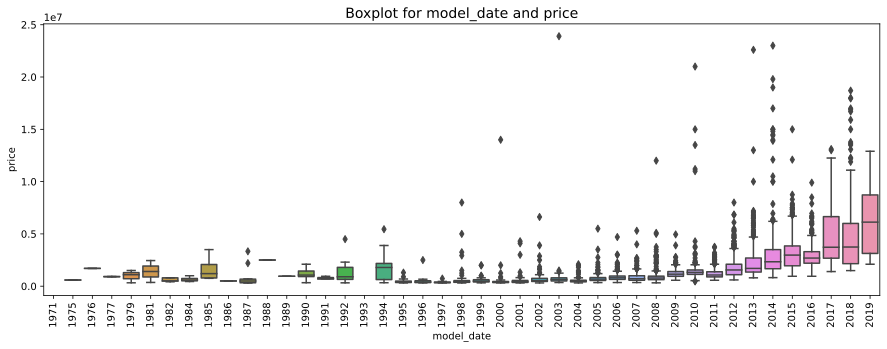

In [460]:
get_boxplot(df_combined,'model_date', 'price', figsize=(15, 5), rotation=90)

The newer the car the higher price. This is logical.
Also there are cars having overprice. Mark them later

{'lower_bound': 1996.5, 'upper_bound': 2024.5, 'outlier_count': 191}
{'lower_bound': 1996.5, 'upper_bound': 2024.5, 'outlier_count': 143}
{'lower_bound': 1996.5, 'upper_bound': 2024.5, 'outlier_count': 48}


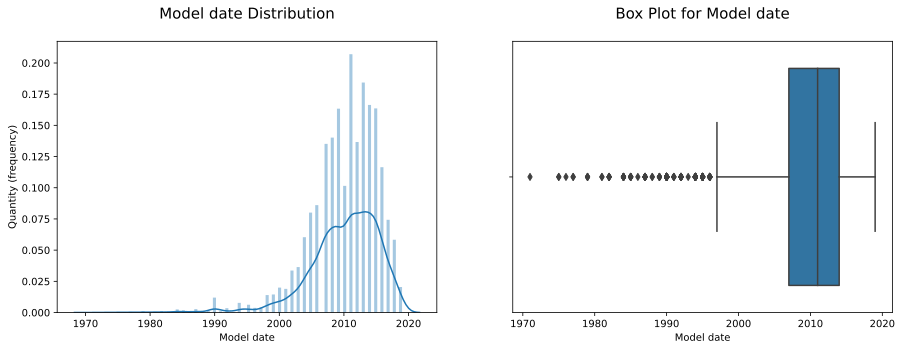

In [461]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(df_combined.model_date.values, bins=100)
plt.title('Model date Distribution\n', fontsize=15)
plt.xlabel('Model date')
plt.ylabel('Quantity (frequency)')
plt.subplot(122)
sns.boxplot(df_combined.model_date.values)
plt.title('Box Plot for Model date\n', fontsize=15)
plt.xlabel('Model date');
df_combined['model_date'].describe()

print(outliers.get_IQR_outliers('model_date'))
print(outliers_train.get_IQR_outliers('model_date'))
print(outliers_test.get_IQR_outliers('model_date'))

We have outliers below 1996.5. Mark them up.

In [462]:
model_outliers = df_combined[df_combined['model_date'] < 1996.5].index
df_combined['model_outliers'] = 0 # Make 0 values column
df_combined.loc[model_outliers, ['model_outliers']] = 1 # Fill column with 1 

This move improve result. Cancel it

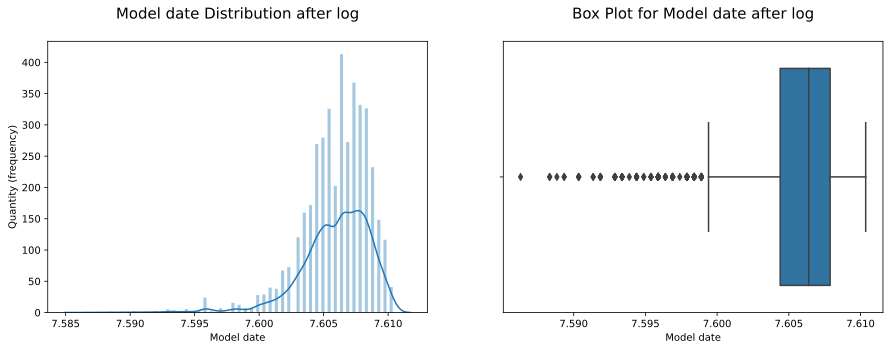

In [463]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(np.log(df_combined.model_date.values ), bins=100)
plt.title('Model date Distribution after log\n', fontsize=15)
plt.xlabel('Model date')
plt.ylabel('Quantity (frequency)')
plt.subplot(122)
sns.boxplot(np.log(df_combined.model_date.values ))
plt.title('Box Plot for Model date after log\n', fontsize=15)
plt.xlabel('Model date');



## **production_date**

{'lower_bound': 1998.5, 'upper_bound': 2026.5, 'outlier_count': 144}

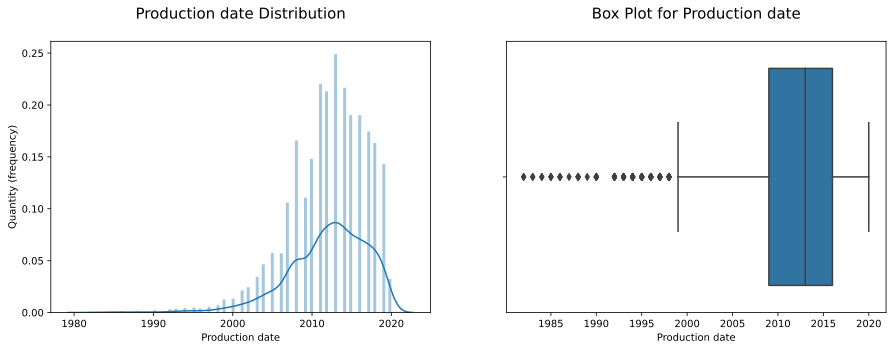

In [464]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(train.production_date.values, bins=100)
plt.title('Production date Distribution\n', fontsize=15)
plt.xlabel('Production date')
plt.ylabel('Quantity (frequency)')
plt.subplot(122)
sns.boxplot(train.production_date.values)
plt.title('Box Plot for Production date\n', fontsize=15)
plt.xlabel('Production date');
df_combined['production_date'].describe()

outliers.get_IQR_outliers('production_date')

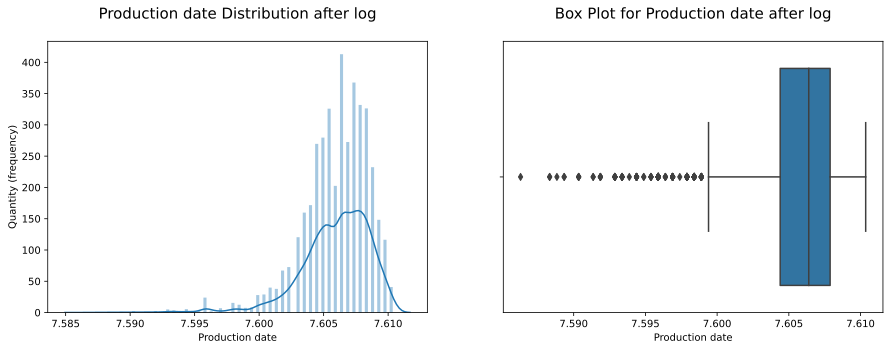

In [465]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(np.log(df_combined.model_date.values), bins=100)
plt.title('Production date Distribution after log\n', fontsize=15)
plt.xlabel('Production date')
plt.ylabel('Quantity (frequency)')
plt.subplot(122)
sns.boxplot(np.log(df_combined.model_date.values))
plt.title('Box Plot for Production date after log\n', fontsize=15)
plt.xlabel('Production date');



In [466]:
# Age of car
df_combined['how_old'] = df_combined['production_date'].apply(lambda x: pd.Timestamp.today().year - x)
    
# mileage per year
df_combined['mile_per_year'] = df_combined['mileage'] / df_combined['how_old']

New features doesn't improve result. Cancel them

## **owning_period**

In [467]:
print(f'Количество пропусков в столбце "owning period" - {round(df_combined.owning_period.isna().sum() / len(df_combined) * 100)}%')

Количество пропусков в столбце "owning period" - 65.0%


Let's delete this column

In [468]:
df_combined.drop('owning_period', axis=1, inplace=True)

# Description

In [469]:
len(set(test.sell_id) & set(train.sell_id))

0

Sellers are unique, or have some accounts

In [470]:
description_set = list(set(test.description) & set(train.description))
len(description_set)

33

There are 33 types of the same descriptions we found. They may belong secondhand dealers or lazy people("Авто в идеале", "Все вопросы по телефону").

Let's mark them

In [471]:
data_for_descriptions= test.append(train, sort=False).reset_index(
    drop=True)  # combine sets

In [472]:
def is_the_same(description):
    if description in description_set:
        return 1
    else:
        return 0

In [473]:
df_combined['description'] = data_for_descriptions['description']
df_combined['same_description'] = 0
df_combined['same_description'] = df_combined['description'].apply(lambda x:is_the_same(x))

In [474]:
df_combined['same_description'].value_counts(normalize=True) * 100

0    91.77541
1     8.22459
Name: same_description, dtype: float64

We can see equal descriptions are quite enought (about 8%)

Marking rows with same description have not improved result. Cancel it

# Conclusions
We are not going to delete outliers, cause they are in test as well, instead of this we have marked some of them. And logarithm them

<a id="sec5.3"></a>
## [5.3 Target Variable](#sec5.3)
[(INDEX)](#sec0)

count    6.682000e+03
mean     1.899868e+06
std      1.914153e+06
min      3.013010e+05
25%      8.000000e+05
50%      1.300000e+06
75%      2.299283e+06
max      2.390000e+07
Name: price, dtype: float64

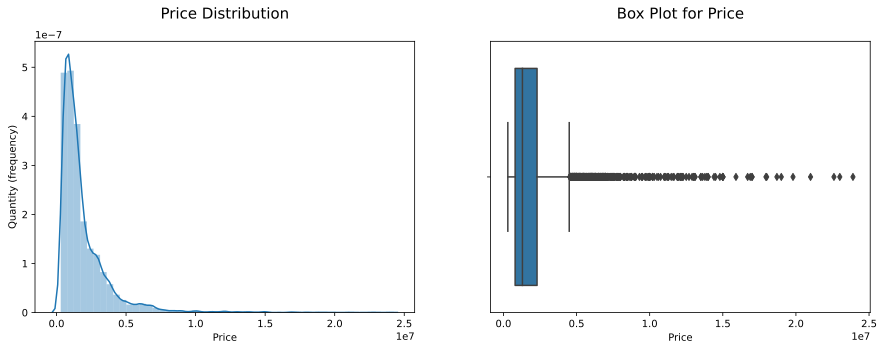

In [475]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(df_combined[df_combined['sample'] == 1]['price'].values, bins=50)
plt.title('Price Distribution\n', fontsize=15)
plt.xlabel('Price')
plt.ylabel('Quantity (frequency)');

plt.subplot(122)
sns.boxplot(df_combined[df_combined['sample'] == 1]['price'].values)
plt.title('Box Plot for Price\n', fontsize=15)
plt.xlabel('Price');

df_combined['price'].describe()

The Target variable has a biased distribution shifted to the left side of 0 to 2.39 millions.

The first and third quartiles are in the range from 800k to 2.39 million, the mean is 1.89 million. Also outliers has been observed for target variable.
We are going to logarithm price column.

count    6.682000e+03
mean     1.899868e+06
std      1.914153e+06
min      3.013010e+05
25%      8.000000e+05
50%      1.300000e+06
75%      2.299283e+06
max      2.390000e+07
Name: price, dtype: float64

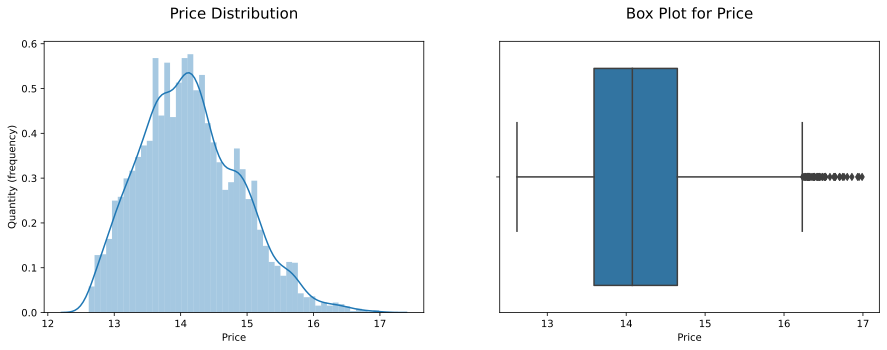

In [476]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(np.log(df_combined[df_combined['sample'] == 1]['price'].values), bins=50)
plt.title('Price Distribution\n', fontsize=15)
plt.xlabel('Price')
plt.ylabel('Quantity (frequency)');

plt.subplot(122)
sns.boxplot(np.log(df_combined[df_combined['sample'] == 1]['price'].values))
plt.title('Box Plot for Price\n', fontsize=15)
plt.xlabel('Price');

df_combined['price'].describe()

In [477]:
df_combined[cat_cols] = df_combined[cat_cols].astype('str')

In [478]:
# Create an instance of our encoder classs
encoder = Encoder(df_combined)

In [479]:
# encode in loop
for col in cat_cols:    
    encoder.label_encoder(col)

Rank of Matrix: 14
Determinant of matrix: 0.1031
Shape of matrix: (14, 14)


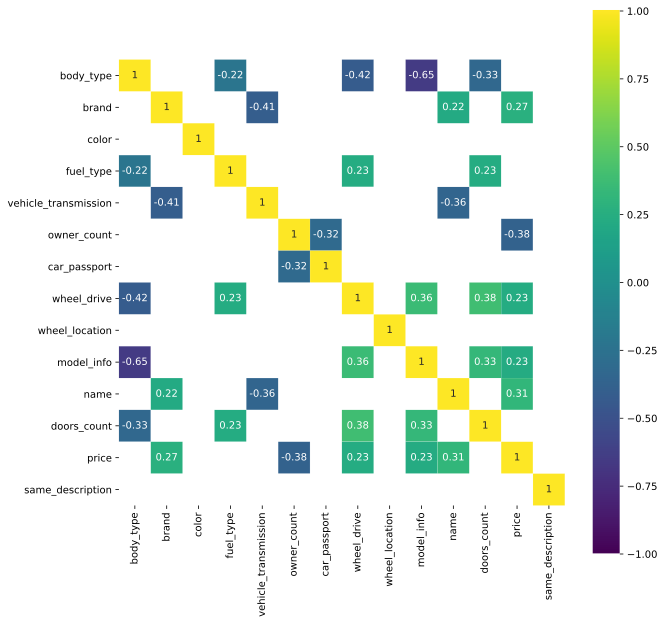

In [480]:
corr_matrix(df_combined[df_combined['sample']==1][cat_cols+['price'] +['same_description']])

See strong correlationn between:
* body_type and model_info(-0.65),
* body_type and wheel_drive(-0.42)

It might be one of them has information about another

In [481]:
df_combined[num_cols] = df_combined[num_cols].astype('float')

Rank of Matrix: 6
Determinant of matrix: 0.003
Shape of matrix: (6, 6)


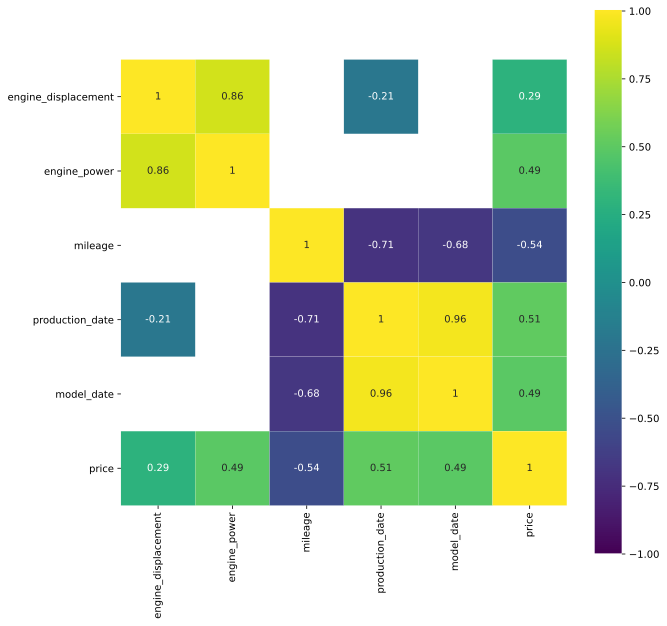

In [482]:
corr_matrix(df_combined[df_combined['sample'] == 1][num_cols+['price']])

See strong correlation between:
*     price and mileage (the higher mileage, the lower price), 
*     price and model_date (the newer model_date, the higher price, 
*     price and engine_power (the higher engine_power, the higher price),
*     mileage and model_date (the lower mileage, the newer model_date),
*     engine_power and engine_displacement (the higher displacement, the higher power)
*     production_date and model_date. One of them will be deleted

We can make new features with engine_power and engine_displacement by multiplication for example.   
*Don't forget electro cars has 0 engine_displacement, but not zero power.*

In [483]:
# Deletion has bad impact on result
# df_combined.drop(['model_date'], axis=1, inplace=True)

In [484]:
cols_to_log = num_cols
df_to_corr = to_log(df_combined, cols_to_log)

In [485]:
df_to_corr[df_to_corr['sample'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6682 entries, 1671 to 8352
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   body_type              6682 non-null   int64  
 1   brand                  6682 non-null   int64  
 2   color                  6682 non-null   int64  
 3   description            6682 non-null   object 
 4   engine_displacement    6682 non-null   float64
 5   engine_power           6682 non-null   float64
 6   fuel_type              6682 non-null   int64  
 7   mileage                6682 non-null   float64
 8   model_date             6682 non-null   float64
 9   model_info             6682 non-null   int64  
 10  name                   6682 non-null   int64  
 11  doors_count            6682 non-null   int64  
 12  production_date        6682 non-null   float64
 13  sell_id                6682 non-null   int64  
 14  vehicle_configuration  6682 non-null   object 
 15  v

Rank of Matrix: 17
Determinant of matrix: 0.0002
Shape of matrix: (17, 17)


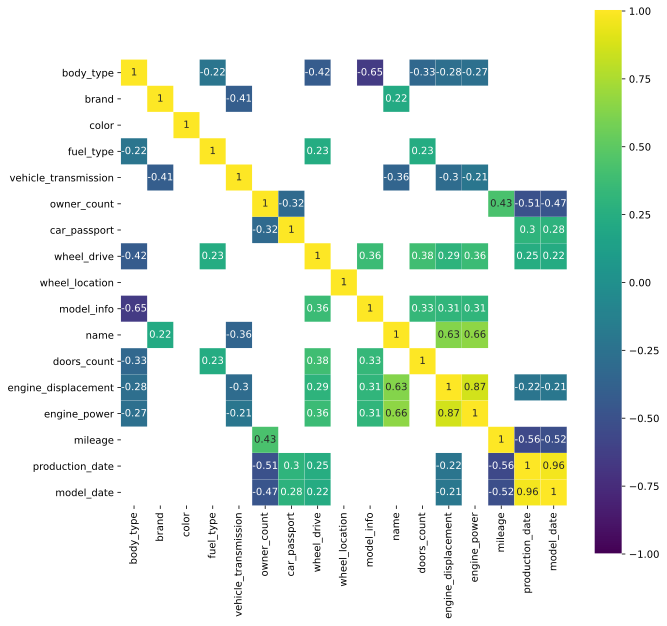

In [486]:
corr_matrix(df_to_corr[df_to_corr['sample'] == 1][cat_cols + num_cols])

# Sentiment

> 

In [487]:
df_sentiment = df_combined[['description']]
df_sentiment['description'] = df_sentiment['description'].fillna('none')
df_sentiment['description'] = df_sentiment['description'].apply(lambda x:remove_trash(x))
df_sentiment['description'] = df_sentiment['description'].apply(lambda x:str(x).lower())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [488]:
# Create new cols and call the func

df_sentiment['subjectivity'] = df_sentiment['description'].apply(
    get_subjectivity)


df_sentiment['polarity'] = df_sentiment['description'].apply(get_polarity)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [489]:
# show data
df_sentiment.sample(6)

description  subjectivity  \
5963  мотор  110cdi 88лсс завода без егр и сажевогоа...           0.0   
4402  состояние нового автомобиля использовался толь...           0.0   
123   продаю собственный автомобиль 3 владельца   су...           0.0   
7908  пишите пожалуйста  вацап если есть вопросыухож...           0.0   
6894  автомобиль для ценителей и коллекционеров все ...           0.0   
8292  более 6 000 проверенных автомобилей с пробегом...           0.0   

      polarity  
5963       0.0  
4402       0.0  
123        0.0  
7908       0.0  
6894       0.0  
8292       0.0

In [490]:
df_sentiment['analysis'] = df_sentiment['polarity'].apply(get_analysis)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [491]:
# Check positive and negative words in percents
df_sentiment['analysis'].value_counts(normalize=True)*100

neutral     86.292350
positive     9.110499
negative     4.597151
Name: analysis, dtype: float64

We can see that most descriptions has neutral polarity.

Most likely, this information is useless for the model for the reason of lack of diversity in positive/negative descriptions. But it indeed to be checked.

<a id="sec6"></a>
## [6. PreProc Tabular Data](#sec6)
[(INDEX)](#sec0)

In [492]:
cat_cols = ['body_type','brand',
            'color','fuel_type',
            'vehicle_transmission',
            'owner_count',
            'car_passport',
            'wheel_drive',
#             'wheel_location',
            'model_info',
            'doors_count'
           ]

num_cols = ['engine_displacement', 
            'engine_power', 
#             'mileage', 
            'production_date',
            'model_date'
           ]
to_hot = ['body_type', 
        'brand', 
        'color', 
        'fuel_type',   
        'doors_count', 
        'vehicle_transmission',
        'wheel_drive',
        'owner_count',
        ]

to_label = ['car_passport', 
            'wheel_location'
           ]


In [493]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # Re-set indexes
    df_output.reset_index(drop=True, inplace=True)
    encoder = Encoder(df_output)
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['sell_id','vehicle_configuration', 'owning_period', 'wheel_location' ], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in df_output.columns:
        missing_vars(df_output, column)
    
    # Очистка данных
    df_output['engine_displacement'] = df_output['engine_displacement'].apply(lambda x:float(str(x).split()[0]) 
                                                                                  if 'undefined' not in str(x) else 0)
    
    df_output['engine_power'] = df_output['engine_power'].apply(lambda x:int(str(x).split()[0]) )    
    df_output['color'] = df_output['color'].apply(lambda x:'other' if x in unpop_colors else x)
    df_output['fuel_type'] = df_output['fuel_type'].apply(lambda x:'other' if x in ['гибрид', 'электро'] else x)
    
    
    power_outliers = df_combined[df_combined['engine_power'] > 489].index
    df_output['power_outlier'] = 0 # Make 0 values column
    df_output.loc[power_outliers, ['power_outlier']] = 1 # Fill column with 1 
    

    

    ######################## Experiment Features  we gave up ######################################################
    
#     # 2.1 displacement
#     mersedeses_2_1 = df_combined[(df_combined['price'] > 500000) & (df_combined['engine_displacement'] == 2.1)].name.index
#     df_output.loc[mersedeses_2_1, ['is_2_1_mers']] =1
#     df_output['is_2_1_mers'] = df_output['is_2_1_mers'].fillna(0)   

#     # Tax increase
#     before_tax_increase = df_output[df_combined['engine_power'] == 190].index # Desired values indices
#     df_output['horses_190'] = 0 # Make 0 values column
#     df_output.loc[before_tax_increase, ['horses_190']] = 1 # Fill column with 1 

#     # Outliers
#     displacement_outliers = df_output[df_output['engine_displacement'] > 4.5].index
#     df_output['displacement_outlier'] = 0 # Make 0 values column
#     df_output.loc[displacement_outliers, ['displacement_outlier']] = 1 # Fill column with 1 

#     mileage_outliers = df_output[df_output['mileage'] > 328841.0].index
#     df_output['mileage_outliers'] = 0 # Make 0 values column
#     df_output.loc[mileage_outliers, ['mileage_outliers']] = 1 # Fill column with 1 

#     model_outliers = df_combined[df_combined['model_date'] < 1996.5].index
#     df_output['model_outliers'] = 0 # Make 0 values column
#     df_output.loc[model_outliers, ['model_outliers']] = 1 # Fill column with 1 
    
    # Sentiment
#     df_output['description'] = df_output['description'].fillna('none')    
#     df_output['description'] = df_sentiment['description'].apply(lambda x:(remove_trash))
#     df_output['description'] = df_sentiment['description'].apply(lambda x:str(x).lower())
#     df_output['polarity'] = df_output['description'].apply(get_polarity)    
#     df_output['analysis'] = df_sentiment['polarity'].apply(get_analysis)
#     df_output['analysis'] = df_output['analysis'].astype('category').cat.codes  

#     # Strange passports
#     df_output['is_strange_passport'] = df_output[['car_passport','owner_count']].apply(lambda x:is_strange_passport(*x), axis=1) 

#      # Age of car
#     df_output['how_old'] = df_output['production_date'].apply(lambda x: pd.Timestamp.today().year - x)
    
#      # Mileage per year
#     df_output['mile_per_year'] = df_output['mileage'] / df_combined['how_old']
    
#      # Description
#     df_combined['description'] = data_for_descriptions['description']
#     df_output['same_description'] = 0
#     df_output['same_description'] = df_output['description'].apply(lambda x:is_the_same(x))

    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in cat_cols +['power_outlier'] :
        df_output[column] = df_output[column].astype('category').cat.codes
    
    # hot it out
    for col in to_hot + ['model_info']:
        df_output = encoder.hot_encoder(col)
    
    
    # ################# Logarithm ###############################
    to_log(df_output, num_cols + ['price'] )
    df_output['mileage'] = np.log(df_output['mileage'].values + 40000) # Empirically identified addition this number show normal distribution
    
    # ################ Scaling ######################################
    scaler = MinMaxScaler()
    for column in num_cols :
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
        
    # ################### Clean #################################################### 
    # Final drop 
    df_output.drop(['description','name', 'model_info'] + ['body_type', 
        'brand', 
        'color', 
        'fuel_type',   
        'doors_count', 
        'vehicle_transmission',
        'wheel_drive',
        'owner_count',
        ], axis = 1, inplace=True)
    
    return df_output

In [494]:
data = test.append(train, sort=False).reset_index(
    drop=True)  # combine sets

In [495]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(5)

engine_displacement  engine_power    mileage  model_date  \
5014             0.743642      0.537235  10.596810    0.979410   
950              0.911231      0.614647  12.611538    0.398715   
7725             0.869613      0.930985  10.596885    1.000000   
2385             0.941988      0.908806  11.325390    0.917580   
3077             0.743642      0.537235  11.338572    0.876308   

      production_date  car_passport      price  sample  power_outlier  \
5014         1.000000             1  15.710909       1              0   
950          0.502374             0        NaN       0              0   
7725         1.000000             1  16.137898       1              0   
2385         0.869501             1  15.536490       1              0   
3077         0.869501             1  14.946913       1              0   

      hot_body_type_0  ...  hot_model_info_112  hot_model_info_113  \
5014              0.0  ...                 0.0                 0.0   
950               0.0  ...                 0.0                 0.0   
7725              0.0  ...                 0.0                 0.0   
2385              0.0  ...                 0.0                 0.0   
3077              0.0  ...                 0.0                 0.0   

      hot_model_info_114  hot_model_info_115  hot_model_info_116  \
5014                 0.0                 1.0                 0.0   
950                  0.0                 0.0                 0.0   
7725                 1.0                 0.0                 0.0   
2385                 0.0                 0.0                 0.0   
3077                 0.0                 0.0                 0.0   

      hot_model_info_117  hot_model_info_118  hot_model_info_119  \
5014                 0.0                 0.0                 0.0   
950                  0.0                 0.0                 0.0   
7725                 0.0                 0.0                 0.0   
2385                 0.0                 0.0                 0.0   
3077                 0.0                 0.0                 0.0   

      hot_model_info_120  hot_model_info_121  
5014                 0.0                 0.0  
950                  0.0                 0.0  
7725                 0.0                 0.0  
2385                 0.0                 0.0  
3077                 0.0                 0.0  

[5 rows x 175 columns]

## Split data

In [496]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [497]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 174 entries, engine_displacement to hot_model_info_121
dtypes: float64(172), int8(2)
memory usage: 2.2 MB


# Model 2: CatBoostRegressor

In [498]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

In [499]:
model = CatBoostRegressor(iterations = 6000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
#                           task_type='GPU'
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

Learning rate set to 0.021181


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0418455	test: 0.0425827	best: 0.0425827 (0)	total: 7.26ms	remaining: 43.5s
100:	learn: 0.0136913	test: 0.0134860	best: 0.0134860 (100)	total: 316ms	remaining: 18.4s
200:	learn: 0.0106042	test: 0.0103838	best: 0.0103838 (200)	total: 600ms	remaining: 17.3s
300:	learn: 0.0098859	test: 0.0096886	best: 0.0096886 (300)	total: 878ms	remaining: 16.6s
400:	learn: 0.0095149	test: 0.0093677	best: 0.0093677 (400)	total: 1.18s	remaining: 16.4s
500:	learn: 0.0092314	test: 0.0091440	best: 0.0091432 (499)	total: 1.45s	remaining: 15.9s
600:	learn: 0.0089456	test: 0.0089436	best: 0.0089436 (600)	total: 1.72s	remaining: 15.4s
700:	learn: 0.0086741	test: 0.0087054	best: 0.0087054 (700)	total: 2.05s	remaining: 15.5s
800:	learn: 0.0084381	test: 0.0085157	best: 0.0085157 (800)	total: 2.32s	remaining: 15.1s
900:	learn: 0.0082378	test: 0.0083523	best: 0.0083523 (900)	total: 2.59s	remaining: 14.7s
1000:	learn: 0.0080554	test: 0.0082247	best: 0.0082247 (1000)	total: 2.87s	remaining: 14.3s
1100:	learn

In [500]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_catboost)))*100:0.2f}%")

TEST mape: 10.96%


In [501]:
df_report = get_regression_metrics(df_report,y_test,test_predict_catboost, 'CatBoostRegressor')

In [502]:
df_report

MAPE            MAE           MSE           RMSE
Naive model        19.877351  347328.243270  8.691772e+11  932296.757864
CatBoostRegressor  10.962336  201913.770472  2.540827e+11  504066.120183

### Submission

In [503]:
model = CatBoostRegressor(iterations = 6000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
#                           task_type='GPU',
                         )
model.fit(X, y,
#          eval_set=(train_data, test_data),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.014023
0:	learn: 0.0421834	total: 6.04ms	remaining: 36.2s
100:	learn: 0.0173223	total: 325ms	remaining: 19s
200:	learn: 0.0119975	total: 631ms	remaining: 18.2s
300:	learn: 0.0105964	total: 926ms	remaining: 17.5s
400:	learn: 0.0100265	total: 1.21s	remaining: 16.9s
500:	learn: 0.0097250	total: 1.5s	remaining: 16.5s
600:	learn: 0.0094764	total: 1.94s	remaining: 17.5s
700:	learn: 0.0092666	total: 2.35s	remaining: 17.8s
800:	learn: 0.0090746	total: 2.63s	remaining: 17.1s
900:	learn: 0.0088928	total: 2.9s	remaining: 16.4s
1000:	learn: 0.0087114	total: 3.18s	remaining: 15.9s
1100:	learn: 0.0085380	total: 3.46s	remaining: 15.4s
1200:	learn: 0.0083853	total: 3.75s	remaining: 15s
1300:	learn: 0.0082556	total: 4.03s	remaining: 14.5s
1400:	learn: 0.0081333	total: 4.31s	remaining: 14.1s
1500:	learn: 0.0080145	total: 4.59s	remaining: 13.8s
1600:	learn: 0.0079141	total: 4.88s	remaining: 13.4s
1700:	learn: 0.0078277	total: 5.16s	remaining: 13s
1800:	learn: 0.0077330	total: 5.44s

In [504]:
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# LGBM + Optuna

In [505]:
# Defining MAPE function since it was removed from sklearn
def mape_11(y_pred,y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.1,random_state=RANDOM_SEED)
    param = {
        'metric': 'mape', 
        'random_state': RANDOM_SEED,
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100,500,700]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = lgb.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    mape = mape_11(np.expm1(test_y), np.expm1(preds))
    
    return mape

In [506]:
import optuna
import lightgbm  as lgb

In [507]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=45)

In [508]:
# # plot_optimization_histor: shows the scores from all trials as 
# # well as the best score so far at each point.
# optuna.visualization.plot_optimization_history(study)

In [509]:
# #Visualize parameter importances.
# optuna.visualization.plot_param_importances(study)

In [510]:
# #Visualize empirical distribution function
# optuna.visualization.plot_edf(study)

In [511]:
# param_lgb = study.best_params

In [512]:
# lgb_opt = lgb.LGBMRegressor(**param_lgb)
# lgb_opt.fit(X_train, y_train,)
# #          eval_set=[(X_test, y_test)],
# #          eval_metric='l1',
# #          early_stopping_rounds=100)


In [513]:
# lgb_opt_pred = lgb_opt.predict(X_test)
# print(f"TEST mape: {(mape(np.exp(y_test), np.exp(lgb_opt_pred)))*100:0.2f}%")

In [514]:
# df_report = get_regression_metrics(df_report,y_test,lgb_opt_pred, 'LGB+optuna')
# df_report

LGB + Optuna gave us worse results then CatBooster

# Model 3: Tabular NN

Построим обычную сеть:

In [515]:
X_train.head(5)

engine_displacement  engine_power    mileage  model_date  \
3903             0.542110      0.217825  11.891362    0.834995   
8335             0.720963      0.447992  12.291227    0.834995   
3944             0.578606      0.366365  11.865489    0.834995   
1755             0.456961      0.150642  11.744037    0.772949   
2746             0.642423      0.310328  13.049793    0.440464   

      production_date  car_passport  power_outlier  hot_body_type_0  \
3903         0.817211             1              0              0.0   
8335         0.764868             1              0              0.0   
3944         0.791046             1              0              0.0   
1755         0.764868             1              0              0.0   
2746         0.291432             0              0              0.0   

      hot_body_type_1  hot_body_type_2  ...  hot_model_info_112  \
3903              0.0              0.0  ...                 0.0   
8335              0.0              0.0  ...                 0.0   
3944              0.0              0.0  ...                 0.0   
1755              0.0              0.0  ...                 0.0   
2746              0.0              0.0  ...                 0.0   

      hot_model_info_113  hot_model_info_114  hot_model_info_115  \
3903                 0.0                 0.0                 0.0   
8335                 0.0                 0.0                 0.0   
3944                 0.0                 0.0                 0.0   
1755                 0.0                 0.0                 0.0   
2746                 0.0                 0.0                 0.0   

      hot_model_info_116  hot_model_info_117  hot_model_info_118  \
3903                 0.0                 0.0                 0.0   
8335                 0.0                 0.0                 0.0   
3944                 0.0                 0.0                 0.0   
1755                 0.0                 0.0                 0.0   
2746                 0.0                 0.0                 0.0   

      hot_model_info_119  hot_model_info_120  hot_model_info_121  
3903                 0.0                 0.0                 0.0  
8335                 0.0                 0.0                 0.0  
3944                 0.0                 0.0                 0.0  
1755                 0.0                 0.0                 0.0  
2746                 0.0                 0.0                 0.0  

[5 rows x 173 columns]

## Simple Dense NN

In [516]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [517]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 512)               89088     
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257       
Total params: 286,465
Trainable params: 286,465
Non-trainable params: 0
________________________________________________

In [518]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [519]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=40, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [520]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=330, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

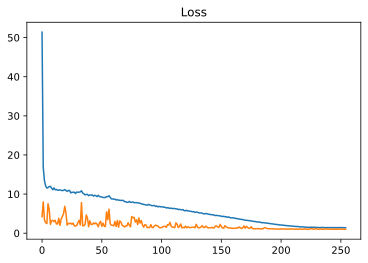

In [521]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [522]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [523]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn1[:,0])))*100:0.2f}%")

TEST mape: 14.50%


In [524]:
df_report = get_regression_metrics(df_report,y_test,model.predict(X_test)[:, 0], 'Simple Dense NN')

In [525]:
df_report

MAPE            MAE           MSE           RMSE
Naive model        19.877351  347328.243270  8.691772e+11  932296.757864
CatBoostRegressor  10.962336  201913.770472  2.540827e+11  504066.120183
Simple Dense NN    14.495310  264379.564275  3.018352e+11  549395.311929

Addition "sigmoid" activation first layer, 'relu' second gave some better result(MAPE 13.06), old scheme gave MAPE 70.
And it's not bad result anyway.

In [526]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = np.exp(sub_predict_nn1[:,0])
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

In [527]:
data.description = df_combined.description
data['description'] = data['description'].astype('unicode')

In [528]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [529]:
#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")
#Preprocess function
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != ' '\
              and token.strip() not in punctuation\
             ]
    text = " ".join(tokens)
    
    return text


In [530]:
data['description'] = data['description'].apply(lambda x:preprocess_text(x))# removing stopwords
data['description'] = data['description'].apply(lambda x:remove_trash(x)) # removing trash

In [531]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [532]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [533]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.2 s, sys: 2.28 ms, total: 1.21 s
Wall time: 1.2 s


In [534]:
# tokenize.word_index

In [535]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(6013, 256) (669, 256) (1671, 256)
CPU times: user 1.25 s, sys: 2.83 ms, total: 1.26 s
Wall time: 1.26 s


In [536]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

авто купить лето  г ода мерседес измайлово состояние новый авто комплект колесо оригинальный диск  радиус   зима      лето ) комплект оригинальный коврик резина ткань комплектация максимальный двигатель указывать фото
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 

In [537]:
text_train.iloc[666]

'автомобиль достаточно живой технический состояние мотор коробка работать подвеска поменять данный момент практически ничто требовать недочет кузов салон отличный состояние чистый прокуривать весь заводской опция работать присылать допы фото запрос прилагать заводской комплектация цвет toledo blau metallic дополнительный оборудование завод  норма токсичность   4  стептроник  система динамический контры устойчивость  гидроусиливать руль сервотроника  многофункциональный рулевой колесо  знак аварийный остановка аптечка  внутр нары зерк затемнение  внутр зеркало автоматич затемнение  активный сидение водитель  подлокотник   система обогр сидный водитель пасс  сист омыватель фара интенс очист стекло  сигнализация авар сближать парк pdc  фара противотуманный  regensensor  ксеноновый фара  автоматический система кондиционирование  спидометр  бортовой компьютер v   система навигация professional  bmw assist  автомобильный телефон беспра трубка  фонарь указатель поворот белый  экспортный испол

### RNN NLP

In [538]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
# model_nlp.add(L.BatchNormalization(axis=1))
model_nlp.add(L.LayerNormalization())

model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Dense(64, activation="sigmoid"))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))




### MLP

In [539]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
# model_nlp.add(L.BatchNormalization(axis=1))
model_nlp.add(L.LayerNormalization())

model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))
# model_mlp.add(L.Dense(1, activation="linear"))

### Multiple Inputs NN

In [540]:
combinedInput = L.concatenate([model_mlp.output, model_nlp.output ])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [541]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 256, 256)     5156608     seq_description[0][0]            
__________________________________________________________________________________________________
layer_normalization_4 (LayerNor (None, 256, 256)     512         embedding_2[0][0]                
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 256, 256)     525312      layer_normalization_4[0][0]      
_______________________________________________________________________________________

### Fit

In [542]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [543]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=20, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [544]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - ETA: 0s - loss: 100.4640 - MAPE: 100.46 - ETA: 1s - loss: 138.5132 - MAPE: 138.51 - ETA: 1s - loss: 114.2198 - MAPE: 114.21 - ETA: 1s - loss: 104.9946 - MAPE: 104.99 - ETA: 1s - loss: 97.9385 - MAPE: 97.9385 - ETA: 1s - loss: 90.5510 - MAPE: 90.55 - ETA: 1s - loss: 81.3904 - MAPE: 81.39 - ETA: 0s - loss: 74.3266 - MAPE: 74.32 - ETA: 0s - loss: 69.7577 - MAPE: 69.75 - ETA: 0s - loss: 64.3938 - MAPE: 64.39 - ETA: 0s - loss: 59.8466 - MAPE: 59.84 - ETA: 0s - loss: 57.5028 - MAPE: 57.50 - 4s 325ms/step - loss: 57.5028 - MAPE: 57.5028 - val_loss: 17.4072 - val_MAPE: 17.4072
Epoch 2/500
12/12 [==============================] - ETA: 0s - loss: 21.4473 - MAPE: 21.44 - ETA: 1s - loss: 17.8002 - MAPE: 17.80 - ETA: 1s - loss: 15.6572 - MAPE: 15.65 - ETA: 1s - loss: 16.1080 - MAPE: 16.10 - ETA: 1s - loss: 16.3728 - MAPE: 16.37 - ETA: 1s - loss: 15.6344 - MAPE: 15.63 - ETA: 1s - loss: 14.9115 - MAPE: 14.91 - ETA: 0s - loss: 14.7196 - MAPE: 14.71 

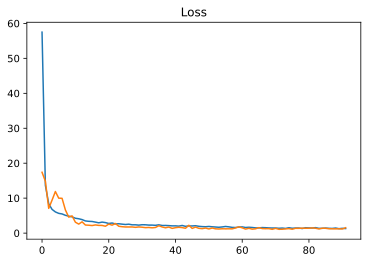

In [546]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [547]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [548]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn2[:,0])))*100:0.2f}%")

TEST mape: 24.99%


In [549]:
df_report = get_regression_metrics(df_report,y_test,test_predict_nn2[:, 0], 'Multiple Inputs NN')

In [550]:
df_report

MAPE            MAE           MSE           RMSE
Naive model         19.877351  347328.243270  8.691772e+11  932296.757864
CatBoostRegressor   10.962336  201913.770472  2.540827e+11  504066.120183
Simple Dense NN     14.495310  264379.564275  3.018352e+11  549395.311929
Multiple Inputs NN  24.988786  434956.204129  5.670607e+11  753034.300622

In [571]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = np.exp(sub_predict_nn2[:,0])
sample_submission.to_csv('nn2_submission.csv', index=False)

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/layers/preprocessing/normalization.py:159 call
        return (inputs - mean) / math_ops.sqrt(variance)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1141 binary_op_wrapper
        raise e
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1125 binary_op_wrapper
        return func(x, y, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:527 subtract
        return gen_math_ops.sub(x, y, name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:10466 sub
        "Sub", x=x, y=y, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 256 and 3 for '{{node functional_7/normalization/sub}} = Sub[T=DT_FLOAT](functional_7/rescaling/add, functional_7/normalization/Reshape)' with input shapes: [?,256], [1,1,1,3].


## Conclusions

Made lemmantisation, remove some trash from description(not ideally)

MAPE 24.99 is the best result we got combine NLP  and Tabular approachs. (Started from 90).
For getting this result we changed the layers activation functions, addition new layers, play with hyperparameters in EarlyStop. Tryed LayerNormalization in keras.
We could use BatchNormalization, but i didn't found a way to right use yet.

Assamble method may improve the our result in  furter.

And spending more time on clearing text can also improve the result.

# Model 5: Добавляем картинки

### Data

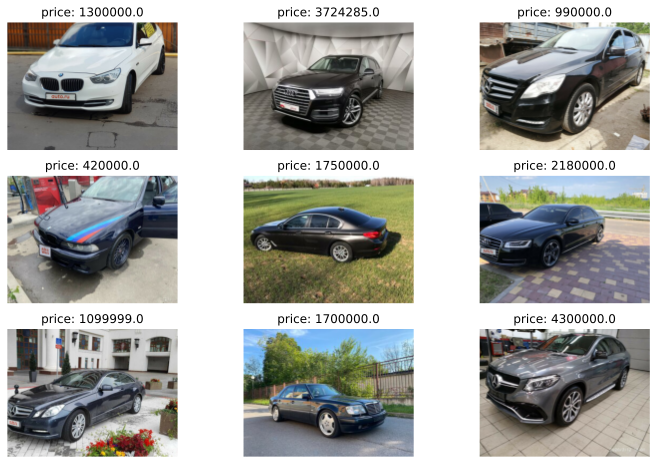

In [551]:
# make sure that the prices and photos are loaded correctly
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [552]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (6013, 240, 320, 3) dtype uint8
images shape (669, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

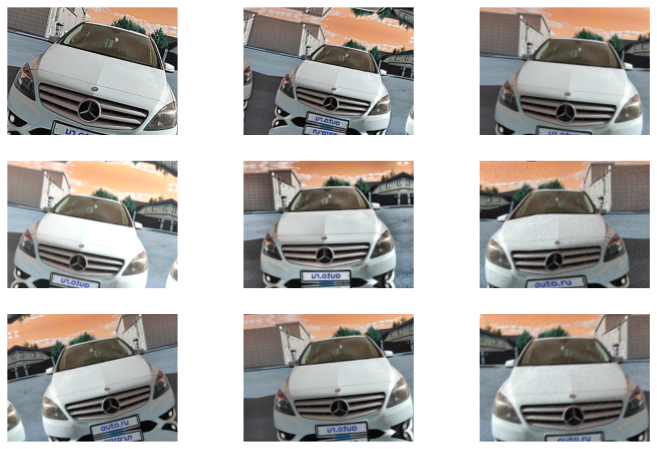

In [553]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#example taken from official documentation: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#example
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [554]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [555]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [556]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#Check errors:
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [557]:
#normalization included in the model EfficientNetB3, therefore, it accepts data of type uint8lisis as input 
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 0us/step


In [558]:
#building a neural network for analyzing tabular data
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'sigmoid'),
    L.LayerNormalization(),
    L.Dropout(0.5),
    L.Dense(256, activation="relu"),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])



In [559]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LayerNormalization(),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.Dense(64, activation="sigmoid"),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64, activation="relu"),
    L.Dropout(0.25)
    ])




In [ ]:
# we combine the outputs of three neural networks
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=14, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [563]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

201/201 [==============================] - ETA: 50s - loss: 12.6204 - MAPE: 12.620 - ETA: 50s - loss: 12.5574 - MAPE: 12.557 - ETA: 49s - loss: 12.5113 - MAPE: 12.511 - ETA: 48s - loss: 12.4521 - MAPE: 12.452 - ETA: 48s - loss: 12.3766 - MAPE: 12.376 - ETA: 47s - loss: 12.3147 - MAPE: 12.314 - ETA: 46s - loss: 12.2456 - MAPE: 12.245 - ETA: 46s - loss: 12.1861 - MAPE: 12.186 - ETA: 45s - loss: 12.1264 - MAPE: 12.126 - ETA: 44s - loss: 12.0616 - MAPE: 12.061 - ETA: 44s - loss: 12.0017 - MAPE: 12.001 - ETA: 43s - loss: 11.9380 - MAPE: 11.938 - ETA: 42s - loss: 11.8733 - MAPE: 11.873 - ETA: 42s - loss: 11.8110 - MAPE: 11.811 - ETA: 41s - loss: 11.7527 - MAPE: 11.752 - ETA: 41s - loss: 11.6985 - MAPE: 11.698 - ETA: 40s - loss: 11.6452 - MAPE: 11.645 - ETA: 39s - loss: 11.5907 - MAPE: 11.590 - ETA: 39s - loss: 11.5366 - MAPE: 11.536 - ETA: 38s - loss: 11.4848 - MAPE: 11.484 - ETA: 37s - loss: 11.4277 - MAPE: 11.427 - ETA: 37s - loss: 11.3796 - MAPE: 11.379 - ETA: 36s - loss: 11.3290 - MAPE: 

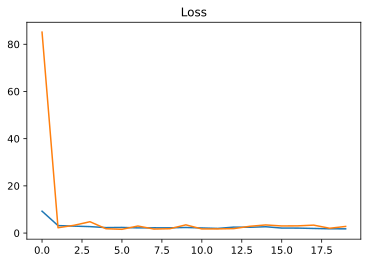

In [564]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [565]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [566]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn3[:,0])))*100:0.2f}%")

TEST mape: 31.73%


In [567]:
df_report = get_regression_metrics(df_report,y_test,test_predict_nn3[:,0], 'NLP + Pictures + Tabular NN')

In [568]:
df_report

MAPE            MAE           MSE  \
Naive model                  19.877351  347328.243270  8.691772e+11   
CatBoostRegressor            10.962336  201913.770472  2.540827e+11   
Simple Dense NN              14.495310  264379.564275  3.018352e+11   
Multiple Inputs NN           24.988786  434956.204129  5.670607e+11   
NLP + Pictures + Tabular NN  31.727229  698342.088658  1.456320e+12   

                                     RMSE  
Naive model                  9.322968e+05  
CatBoostRegressor            5.040661e+05  
Simple Dense NN              5.493953e+05  
Multiple Inputs NN           7.530343e+05  
NLP + Pictures + Tabular NN  1.206781e+06

In [569]:
sub_predict_nn3 = np.exp(model.predict(sub_dataset.batch(30)))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [574]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(blend_predict)))*100:0.2f}%")

TEST mape: 19.50%


In [573]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [576]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
model_nlp.add(L.LayerNormalization())
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))




In [577]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="model_date")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.model_date.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [578]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [579]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_42_input (InputLayer)     [(None, 173)]        0                                            
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 512)          89088       dense_42_input[0][0]             
__________________________________________________________________________________________________
dropout_29 (Dropout)            (None, 512)          0           dense_42[0][0]                   
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 256)          131328      dropout_29[0][0]                 
_______________________________________________________________________________________

In [580]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [581]:
history = model.fit([X_train, X_train.model_date.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.model_date.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - ETA: 0s - loss: 101.3176 - MAPE: 101.31 - 0s 25ms/step - loss: 60.4935 - MAPE: 60.4935 - val_loss: 35.4170 - val_MAPE: 35.4170
Epoch 2/500
12/12 [==============================] - ETA: 0s - loss: 33.2925 - MAPE: 33.29 - 0s 9ms/step - loss: 20.6117 - MAPE: 20.6117 - val_loss: 10.7320 - val_MAPE: 10.7320
Epoch 3/500
12/12 [==============================] - ETA: 0s - loss: 18.9564 - MAPE: 18.95 - ETA: 0s - loss: 14.9738 - MAPE: 14.97 - 0s 15ms/step - loss: 14.5811 - MAPE: 14.5811 - val_loss: 10.6329 - val_MAPE: 10.6329
Epoch 4/500
12/12 [==============================] - ETA: 0s - loss: 12.4394 - MAPE: 12.43 - ETA: 0s - loss: 11.8104 - MAPE: 11.81 - 0s 13ms/step - loss: 11.7592 - MAPE: 11.7592 - val_loss: 7.3098 - val_MAPE: 7.3098
Epoch 5/500
12/12 [==============================] - ETA: 0s - loss: 10.6822 - MAPE: 10.68 - ETA: 0s - loss: 10.6166 - MAPE: 10.61 - 0s 14ms/step - loss: 10.5796 - MAPE: 10.5796 - val_loss: 7.8685 - val_MAPE: 

In [582]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.model_date.values])
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn_bonus[:,0])))*100:0.2f}%")

TEST mape: 20.35%


In [584]:
sub_predict_nn666 = np.exp(model.predict([X_sub, X_sub.model_date.values])[:, 0])
sample_submission['price'] = sub_predict_nn666
sample_submission.to_csv('nn666_submission.csv', index=False)

